Астроциты - это определеный тип глиальных клеток, из них состоит мозговое вещество.
Астроциты выполняют разнообразные функции такие как: поддержка нейронов, образование барьеров между кровью и мозговым веществом, управление нейромедиаторами, поддержание гомеостаза.

Нейроны - основные функциональные и структурные единицы нервной системы, способные к генерации и передаче электрических сигналов.
Нейроны отвечают за обработку и передачу информации в виде электрических импульсов, которые позволяют нам воспринимать окружающий мир, мыслить, чувствовать и действовать.

Tripartite synapse (Трехсторонний синапс) -  это концепция, предполагающая, что синапс это не только соединение нейронов, а что туда входит еще и глиальные астроциты, которые выполняют важную роль в передаче сигналов и функционировании мозга.
В таком синапсе нейроны передают сигналы друг другу через синапсы, а глиальные клетки, в частности астроциты, участвуют в регуляции и модуляции этого процесса, а также поддерживают окружающую среду нейронов.

In [4]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted

### Чтение данных

In [ ]:
def load_images_and_create_dataframe(folder, name_dataset):
    data = []
    image_names = natsorted(os.listdir(folder))
    for image_name in image_names:
        image_path = os.path.join(folder, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image_data = {
            'dataset': name_dataset,
            'image_name': image_name,
            'image_path': image_path,
            'image_size': image.shape}
        data.append(image_data)
    df = pd.DataFrame(data)
    return df


def create_folders_lists(main_path):
    event_folders = []
    activity_folders = []
    folder_names = []
    for folder_name in os.listdir(main_path):
        folder_names.append(folder_name)
        folder_path = os.path.join(main_path, folder_name)
        subfolders = os.listdir(folder_path)
        event_folder_path = os.path.join(folder_path, subfolders[0])
        activity_folder_path = os.path.join(folder_path, subfolders[1])

        event_folders.append(event_folder_path)
        activity_folders.append(activity_folder_path)

    return event_folders, activity_folders, folder_names

### Задание 6.3. средняя площадь области в зависимости от времени.

In [ ]:
def find_count_white_areas(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    contours = cv2.findContours(
        image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    white_areas_count = 0
    total_area = 0

    for contour in contours:
        area = cv2.contourArea(contour)
        white_areas_count += 1
        total_area += area

    spatial_scale = 5.1
    avg_area_in_pixels = total_area / white_areas_count if white_areas_count > 0 else 0
    avg_area_in_mkm = avg_area_in_pixels / \
        (spatial_scale ** 2) if avg_area_in_pixels > 0 else 0

    return white_areas_count, avg_area_in_mkm


def adding_information_about_white_areas(df):
    white_areas_count = []
    average_areas = []
    for image_path in df['image_path']:
        result_function_1 = find_count_white_areas(image_path)
        white_areas_count.append(result_function_1[0])
        average_areas.append(result_function_1[1])

    df['white_areas_count'] = white_areas_count
    df['average_area'] = average_areas

    return df


def graph_average_area(df):

    df['time_seconds'] = df.index / 2

    gragh = plt.figure(figsize=(6.7, 3.11), dpi=300)
    plt.plot(df['time_seconds'], df['average_area'],
             color='#DA70D6', linewidth=3)
    plt.xlabel('Время, c')
    plt.ylabel('Средняя площадь области, мкм²')
    plt.title('Средняя площадь области в зависимости от времени')
    plt.xlim(df['time_seconds'].min(), df['time_seconds'].max())
    plt.ylim(df['average_area'].min(), df['average_area'].max())
    plt.legend(['Средняя площадь'], loc='upper right')
    plt.tight_layout()
    plt.show()
    return gragh


def save_graph(gragh, name_graph_png, name_graph_svg):
    gragh.savefig(name_graph_png)
    gragh.savefig(name_graph_svg)


def save_data_average_area(df, name_table):
    time_average_area_df = df[['time_seconds', 'average_area']].copy()
    print(time_average_area_df)
    time_average_area_df.to_excel(name_table)

### Задание 6.12. максимум интенсивности внутри самой большой области в зависимости от времени.

In [ ]:
def find_coordinates_largest_white_area(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    contours = cv2.findContours(
        image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    largest_area = 0
    largest_area_contour = 0

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > largest_area:
            largest_area = area
            largest_area_contour = contour

    pixel_coordinates = []
    for pixel in largest_area_contour:
        x, y = pixel[0]
        pixel_coordinates.append((x, y))
    return pixel_coordinates


def adding_pixel_coordinates(df1, df2):
    all_pixel_coordinates = []
    for image_path in df1['image_path']:
        result_function_2 = find_coordinates_largest_white_area(image_path)
        all_pixel_coordinates.append(result_function_2)
    df2['pixel_coordinates'] = all_pixel_coordinates
    return df2


def find_max_intensity_in_area(path, pixel_coordinates):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    max_intensity = 0

    for coordinates in pixel_coordinates:
        x, y = coordinates
        intensity = image[y, x]
        max_intensity = max(intensity, max_intensity)

    return max_intensity


def adding_max_intensity(df):
    max_intensities = []
    for image_path, pixel_coordinates in zip(df['image_path'], df['pixel_coordinates']):
        result_function_3 = find_max_intensity_in_area(
            image_path, pixel_coordinates)
        max_intensities.append(result_function_3)
    df['max_intensity'] = max_intensities
    return df


def plot_graph_intensity(df):
    df['time_seconds'] = df.index / 2

    gragh = plt.figure(figsize=(6.7, 3.11), dpi=300)
    plt.plot(df['time_seconds'], df['max_intensity'],
             color='#800020', linewidth=3)
    plt.xlabel('Время, c')
    plt.ylabel('Максимальная интенсивность')
    plt.title('Максимальная интенсивность в зависимости от времени')
    plt.xlim(df['time_seconds'].min(), df['time_seconds'].max())
    plt.ylim(df['max_intensity'].min(), df['max_intensity'].max())
    plt.legend(['Максимальная интенсивность'], loc='upper right')
    plt.tight_layout()
    plt.show()
    return gragh


def save_graph(gragh, name_graph_png, name_graph_svg):
    gragh.savefig(name_graph_png)
    gragh.savefig(name_graph_svg)


def save_data_max_intensity(df, name_table):
    time_max_intensity_df = df[['time_seconds', 'max_intensity']].copy()
    print(time_max_intensity_df)
    time_max_intensity_df.to_excel(name_table)

### Функция для запуска всех функций

In [ ]:
def function_runs_all_functions(main_path):
    event_folders, activity_folders, folder_names = create_folders_lists(
        main_path)

    for i in range(len(event_folders)):
        event_path = event_folders[i]
        activity_path = activity_folders[i]
        events_df = load_images_and_create_dataframe(event_path, 'event')
        activities_df = load_images_and_create_dataframe(
            activity_path, 'activity')
        events_df = adding_information_about_white_areas(events_df)
        graph_average = graph_average_area(events_df)
        folder_name = folder_names[i]
        path_to_save = rf'C:\Users\Vector\Desktop\Final\Результаты работы функций\{folder_name}'
        os.chdir(path_to_save)
        save_graph(
            graph_average, f'График средней площади_{i + 1}.png', f'График средней площади_{i + 1}.svg')
        save_data_average_area(
            events_df, f'Таблица средней площади_{i + 1}.xlsx')

        activities_df = adding_pixel_coordinates(events_df, activities_df)
        activities_df = adding_max_intensity(activities_df)
        graph_intensity = plot_graph_intensity(activities_df)
        save_graph(
            graph_intensity, f'График максимальной интенсивности_{i + 1}.png', f'График максимальной интенсивности_{i + 1}.svg')
        save_data_max_intensity(
            activities_df, f'Таблица максимальной интенсивности_{i + 1}.xlsx')

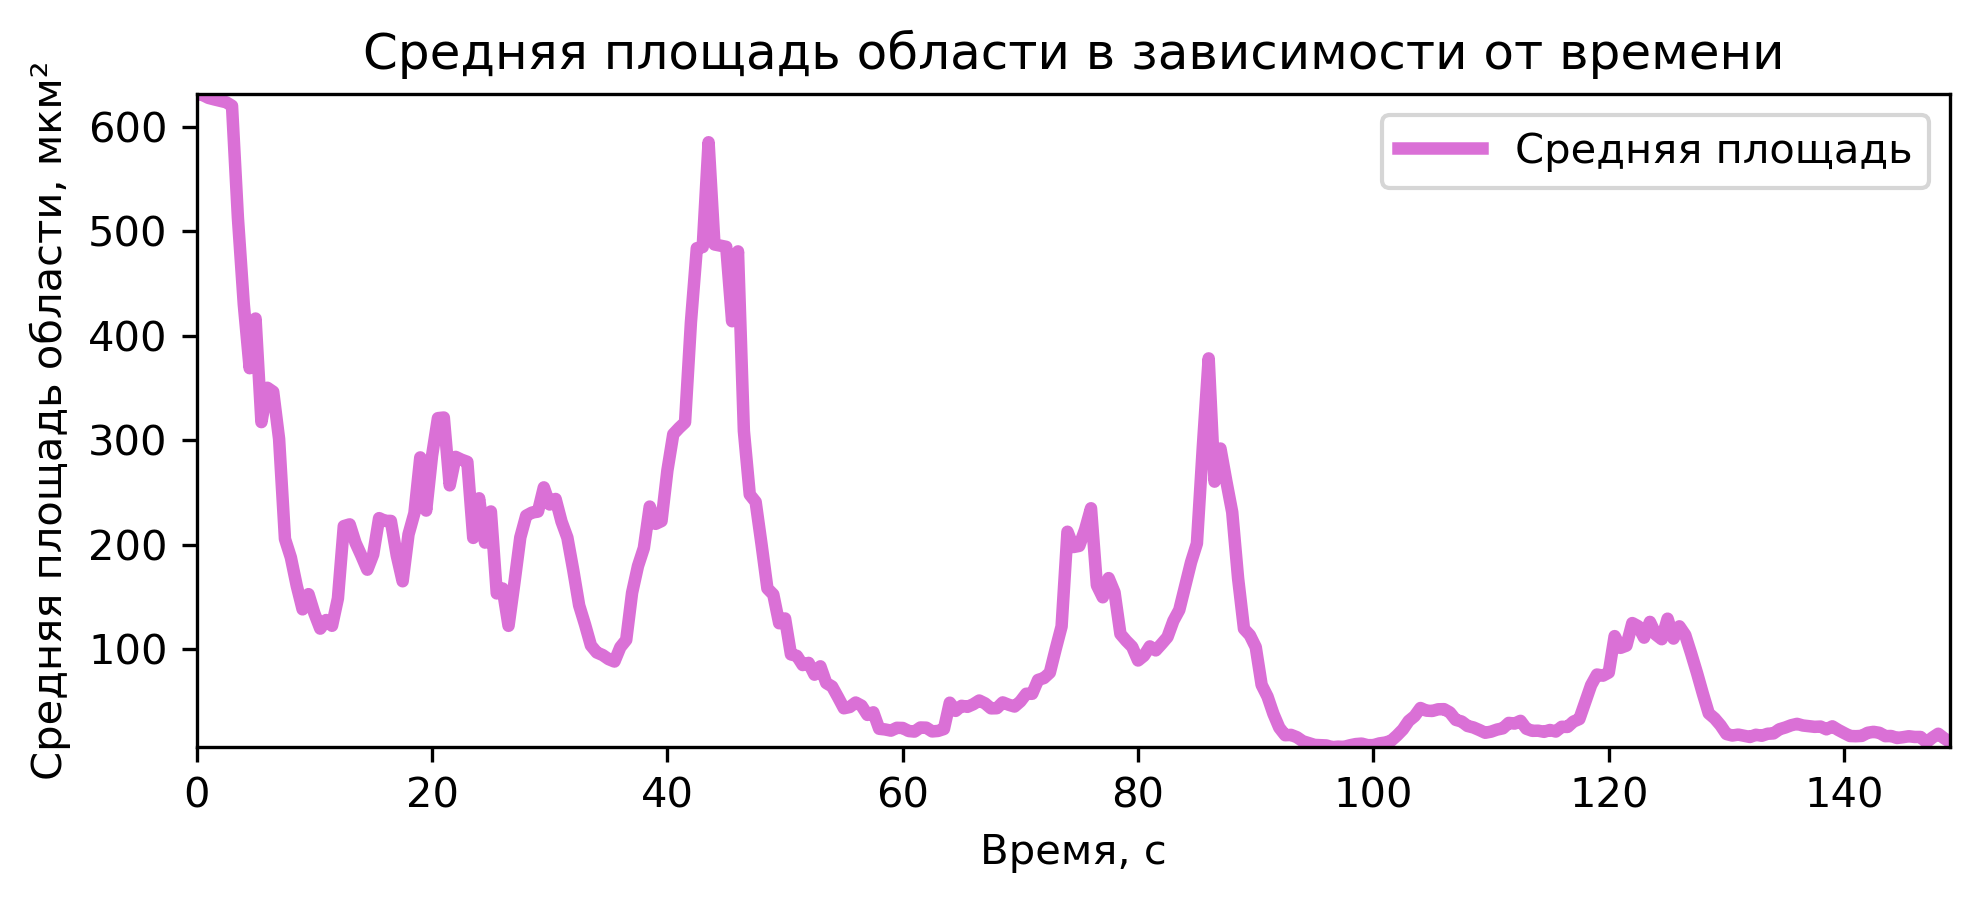

     time_seconds  average_area
0             0.0    631.268743
1             0.5    630.630527
2             1.0    627.812380
3             1.5    626.339869
4             2.0    625.017301
..            ...           ...
294         147.0     10.946339
295         147.5     15.502135
296         148.0     19.225939
297         148.5     14.901151
298         149.0     11.397860

[299 rows x 2 columns]


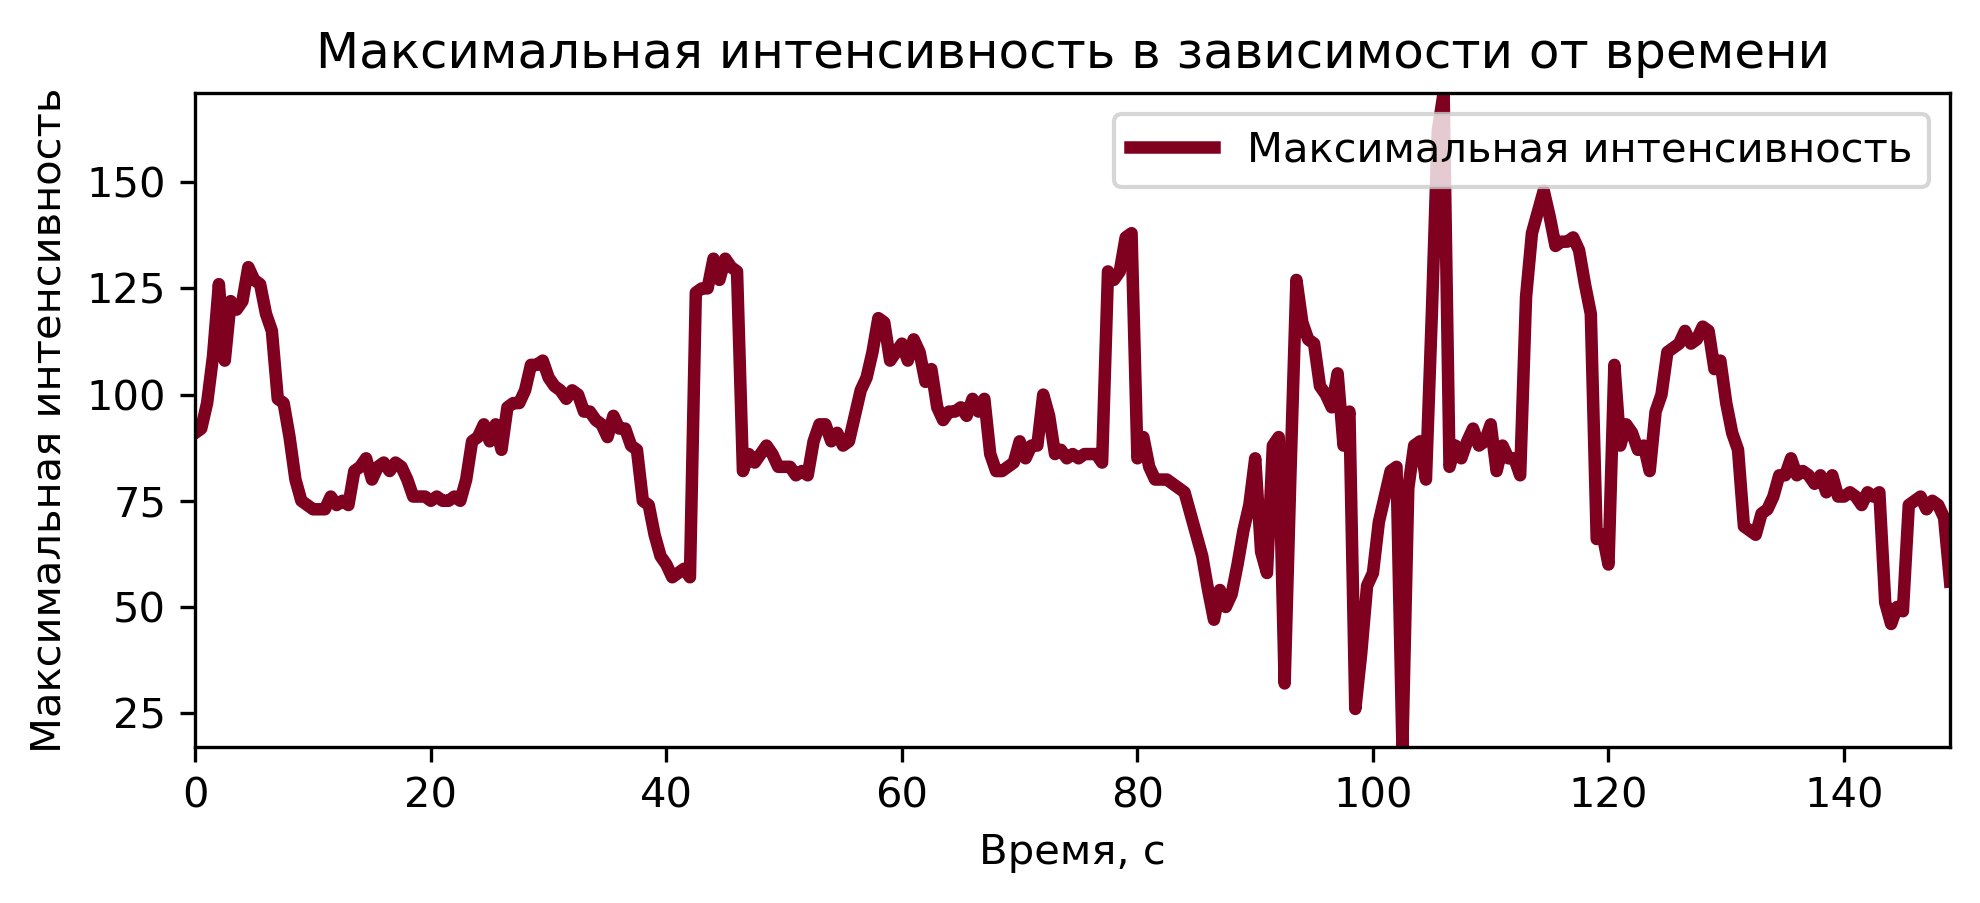

     time_seconds  max_intensity
0             0.0             91
1             0.5             92
2             1.0             98
3             1.5            109
4             2.0            126
..            ...            ...
294         147.0             73
295         147.5             75
296         148.0             74
297         148.5             71
298         149.0             56

[299 rows x 2 columns]


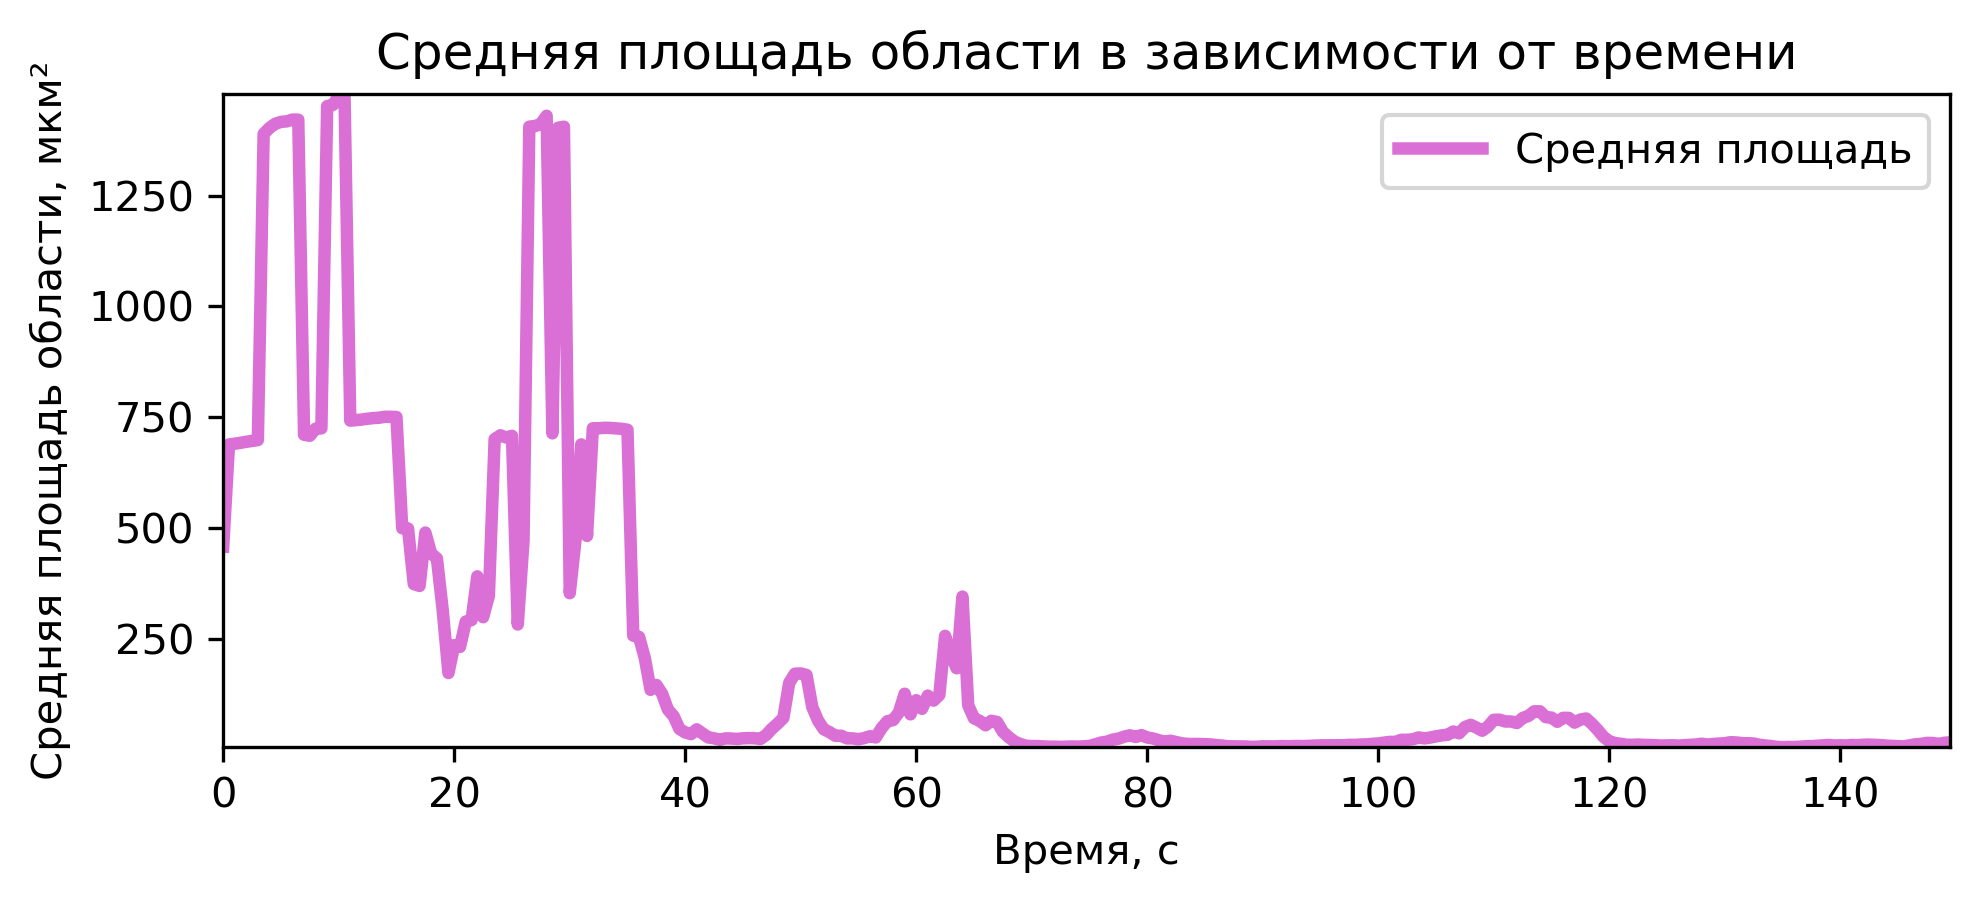

     time_seconds  average_area
0             0.0    458.592849
1             0.5    688.840830
2             1.0    690.522876
3             1.5    692.579777
4             2.0    694.934641
..            ...           ...
295         147.5     16.033577
296         148.0     15.796809
297         148.5     13.786196
298         149.0     16.220006
299         149.5     17.155167

[300 rows x 2 columns]


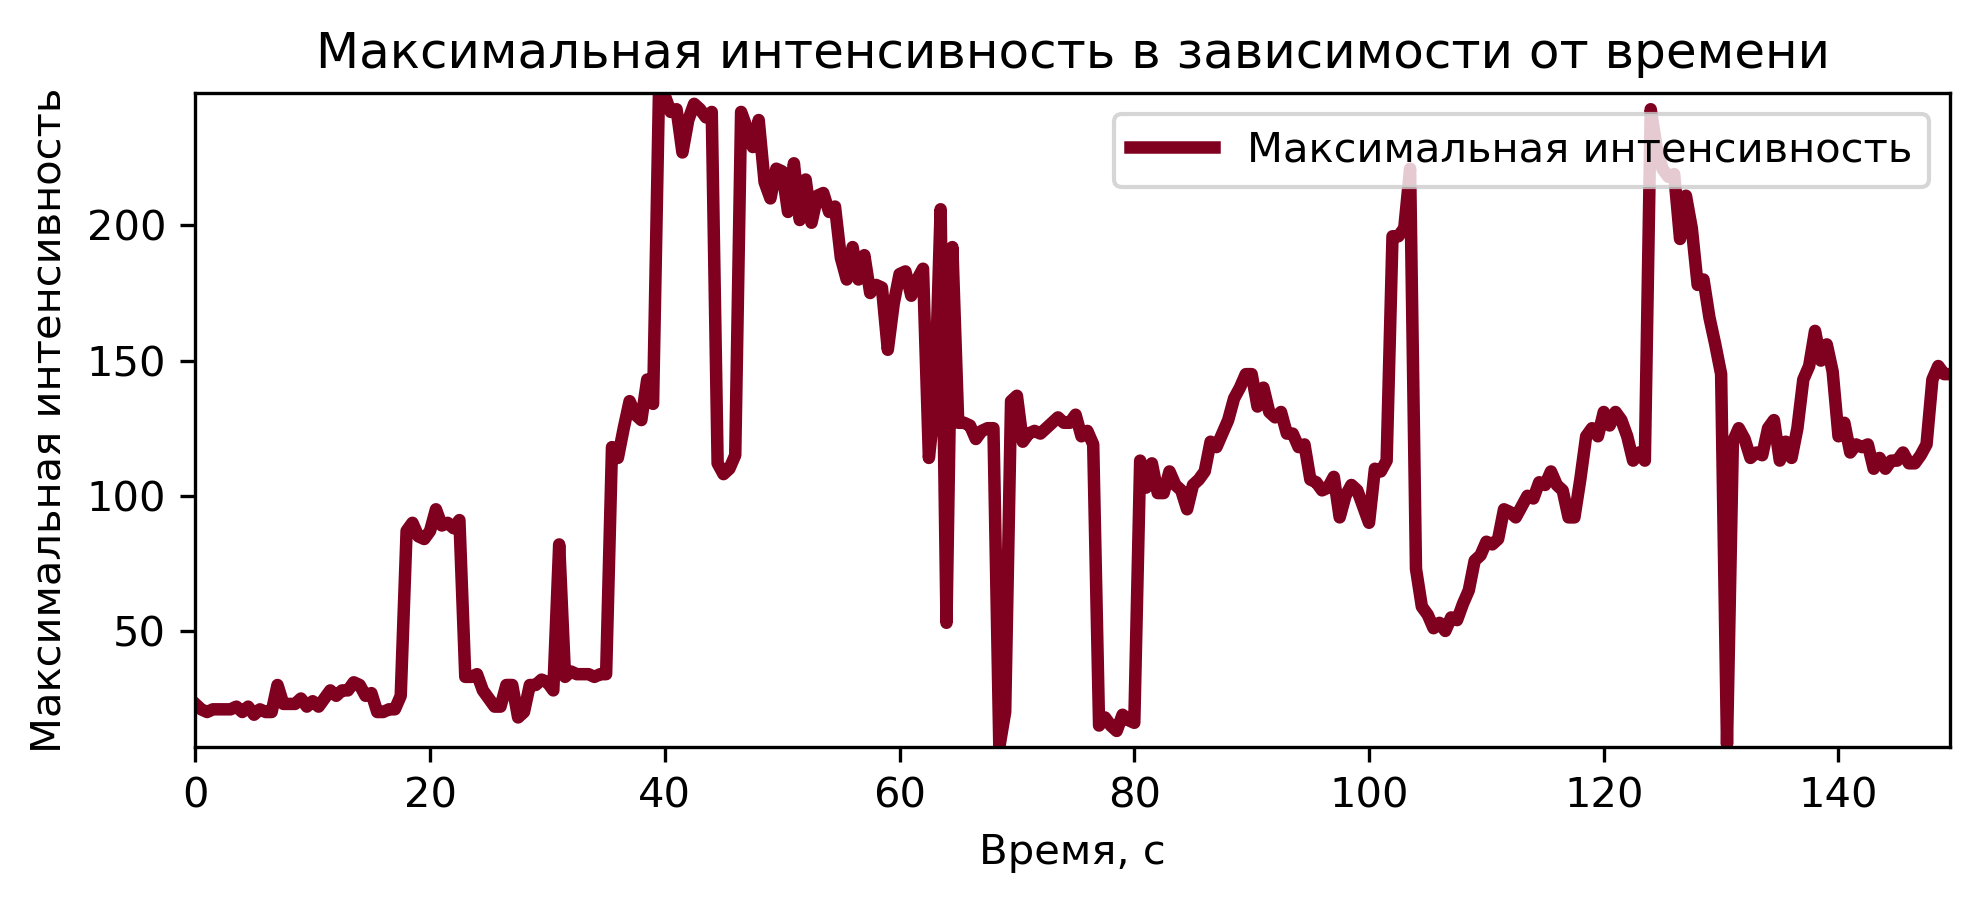

     time_seconds  max_intensity
0             0.0             23
1             0.5             21
2             1.0             20
3             1.5             21
4             2.0             21
..            ...            ...
295         147.5            119
296         148.0            143
297         148.5            148
298         149.0            145
299         149.5            145

[300 rows x 2 columns]


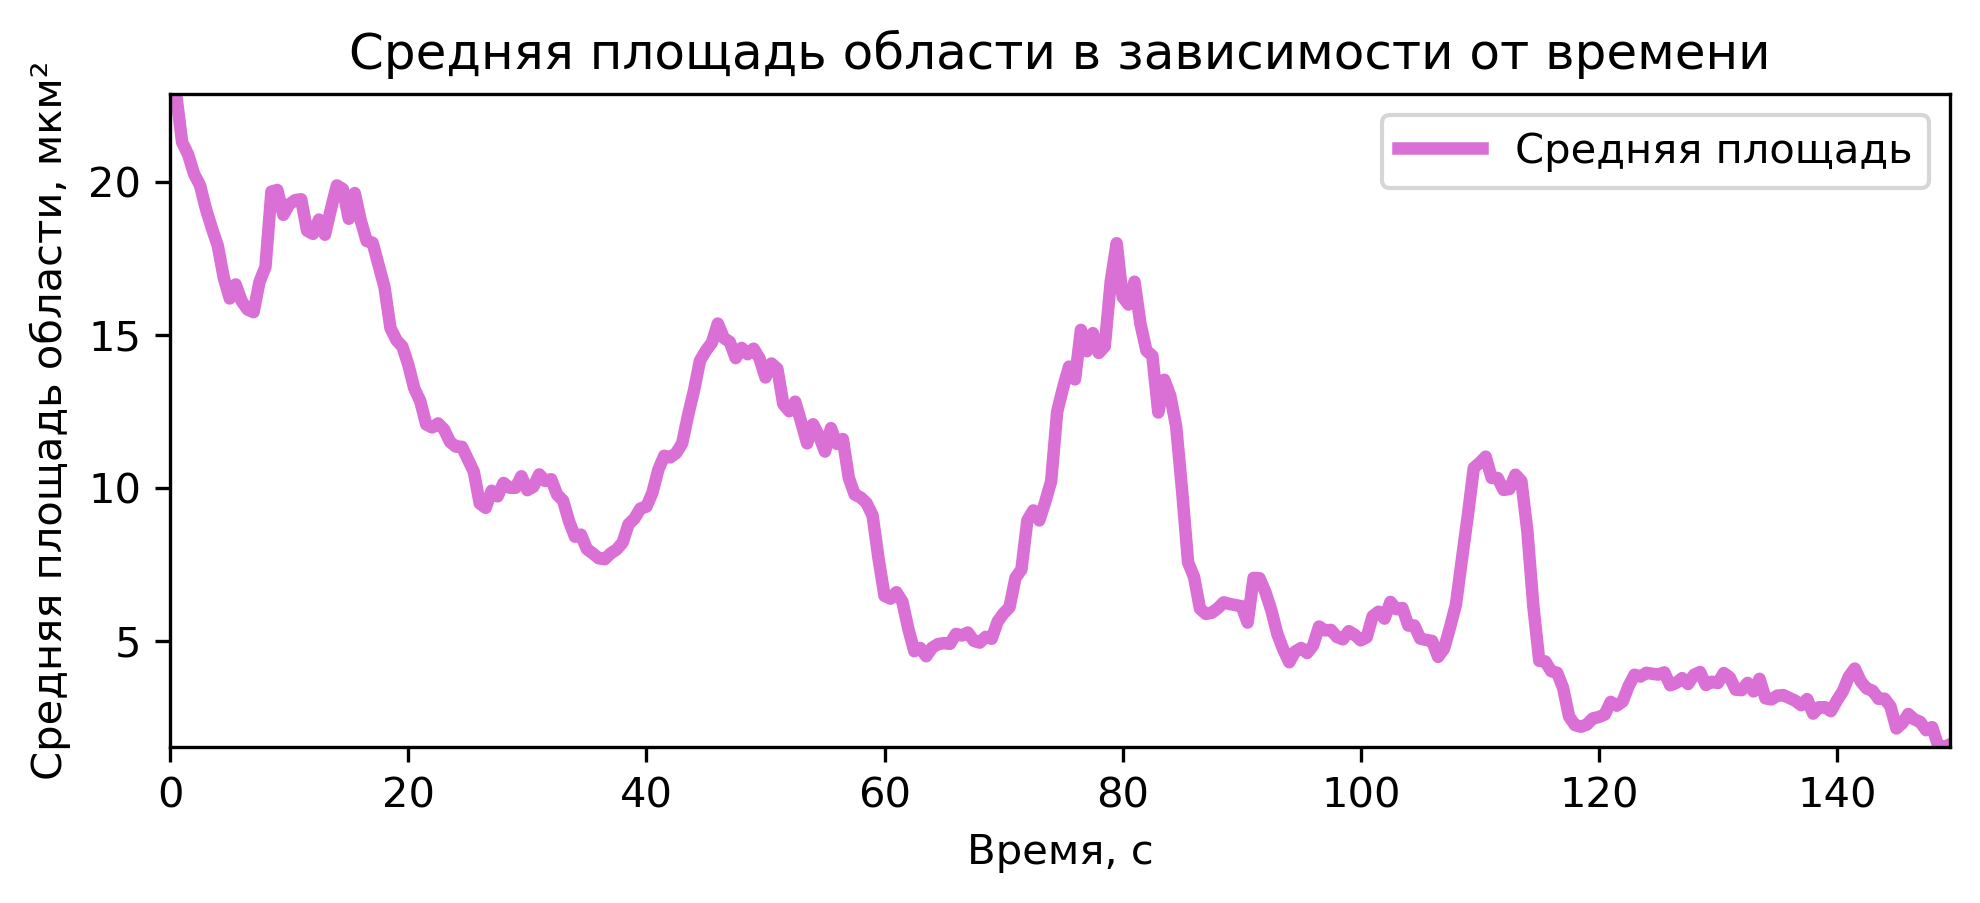

     time_seconds  average_area
0             0.0     22.645400
1             0.5     22.871812
2             1.0     21.304493
3             1.5     20.907886
4             2.0     20.272972
..            ...           ...
295         147.5      2.089196
296         148.0      2.190549
297         148.5      1.594704
298         149.0      1.536039
299         149.5      1.628928

[300 rows x 2 columns]


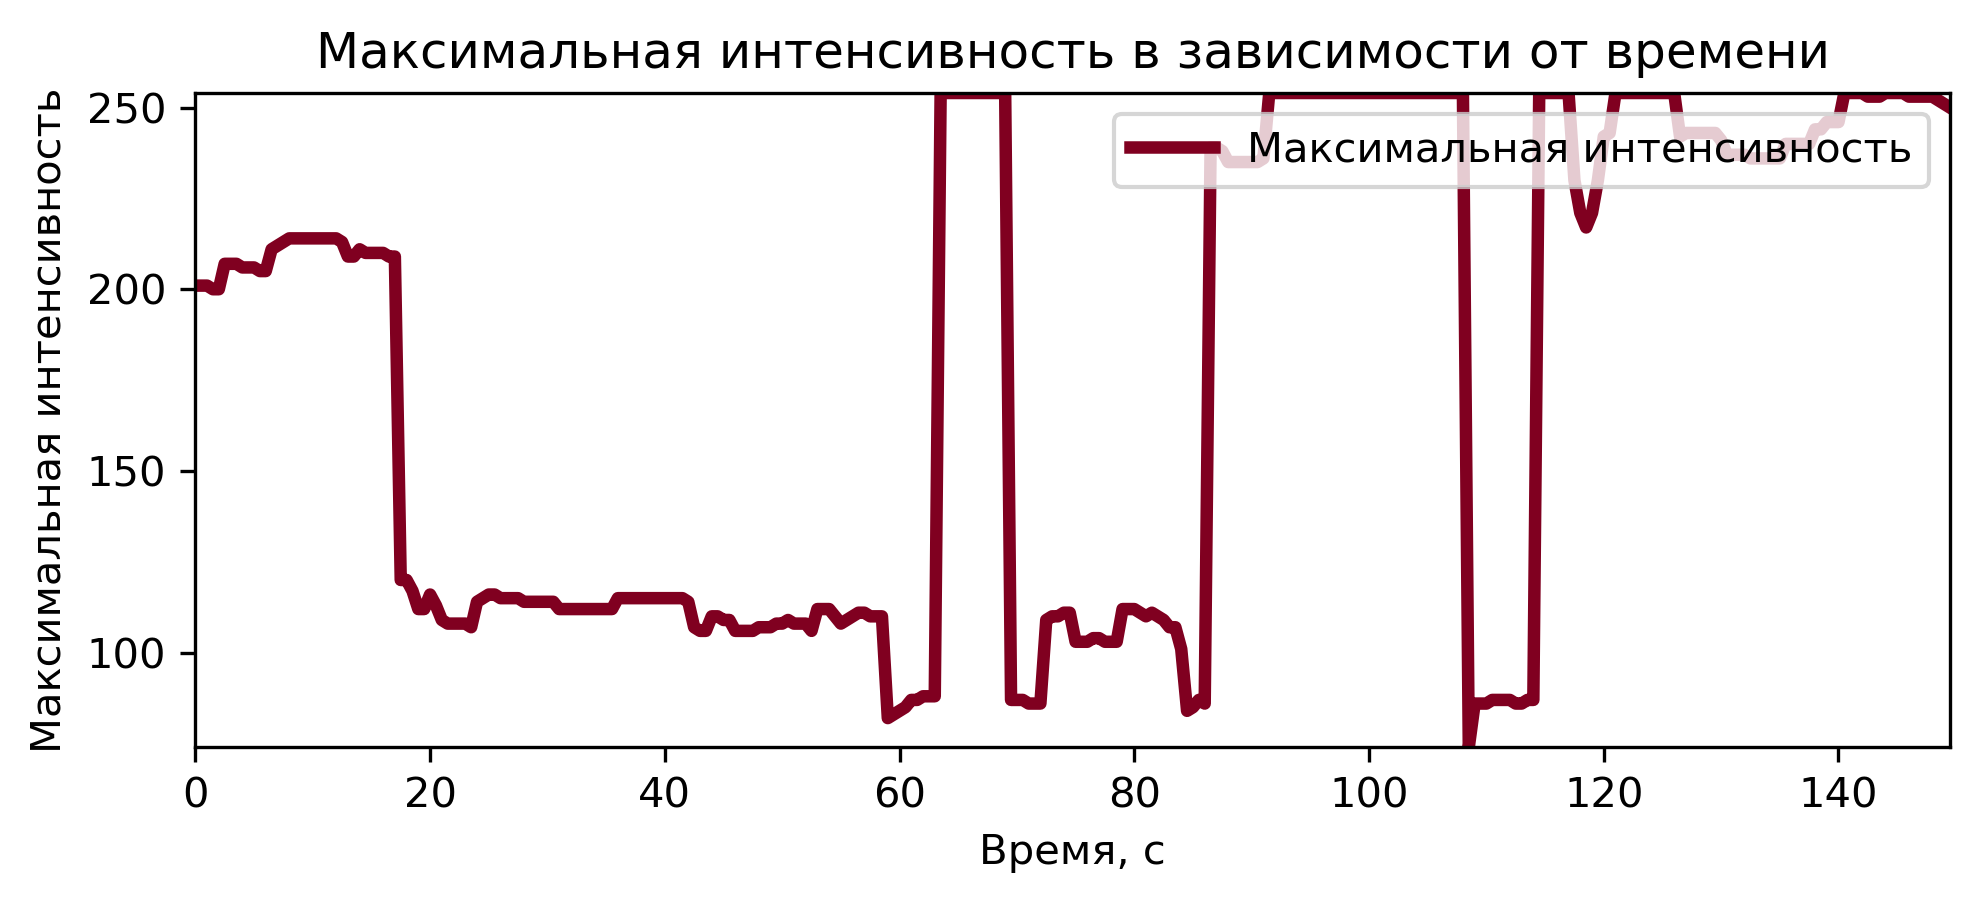

     time_seconds  max_intensity
0             0.0            201
1             0.5            201
2             1.0            201
3             1.5            200
4             2.0            200
..            ...            ...
295         147.5            253
296         148.0            253
297         148.5            252
298         149.0            251
299         149.5            250

[300 rows x 2 columns]


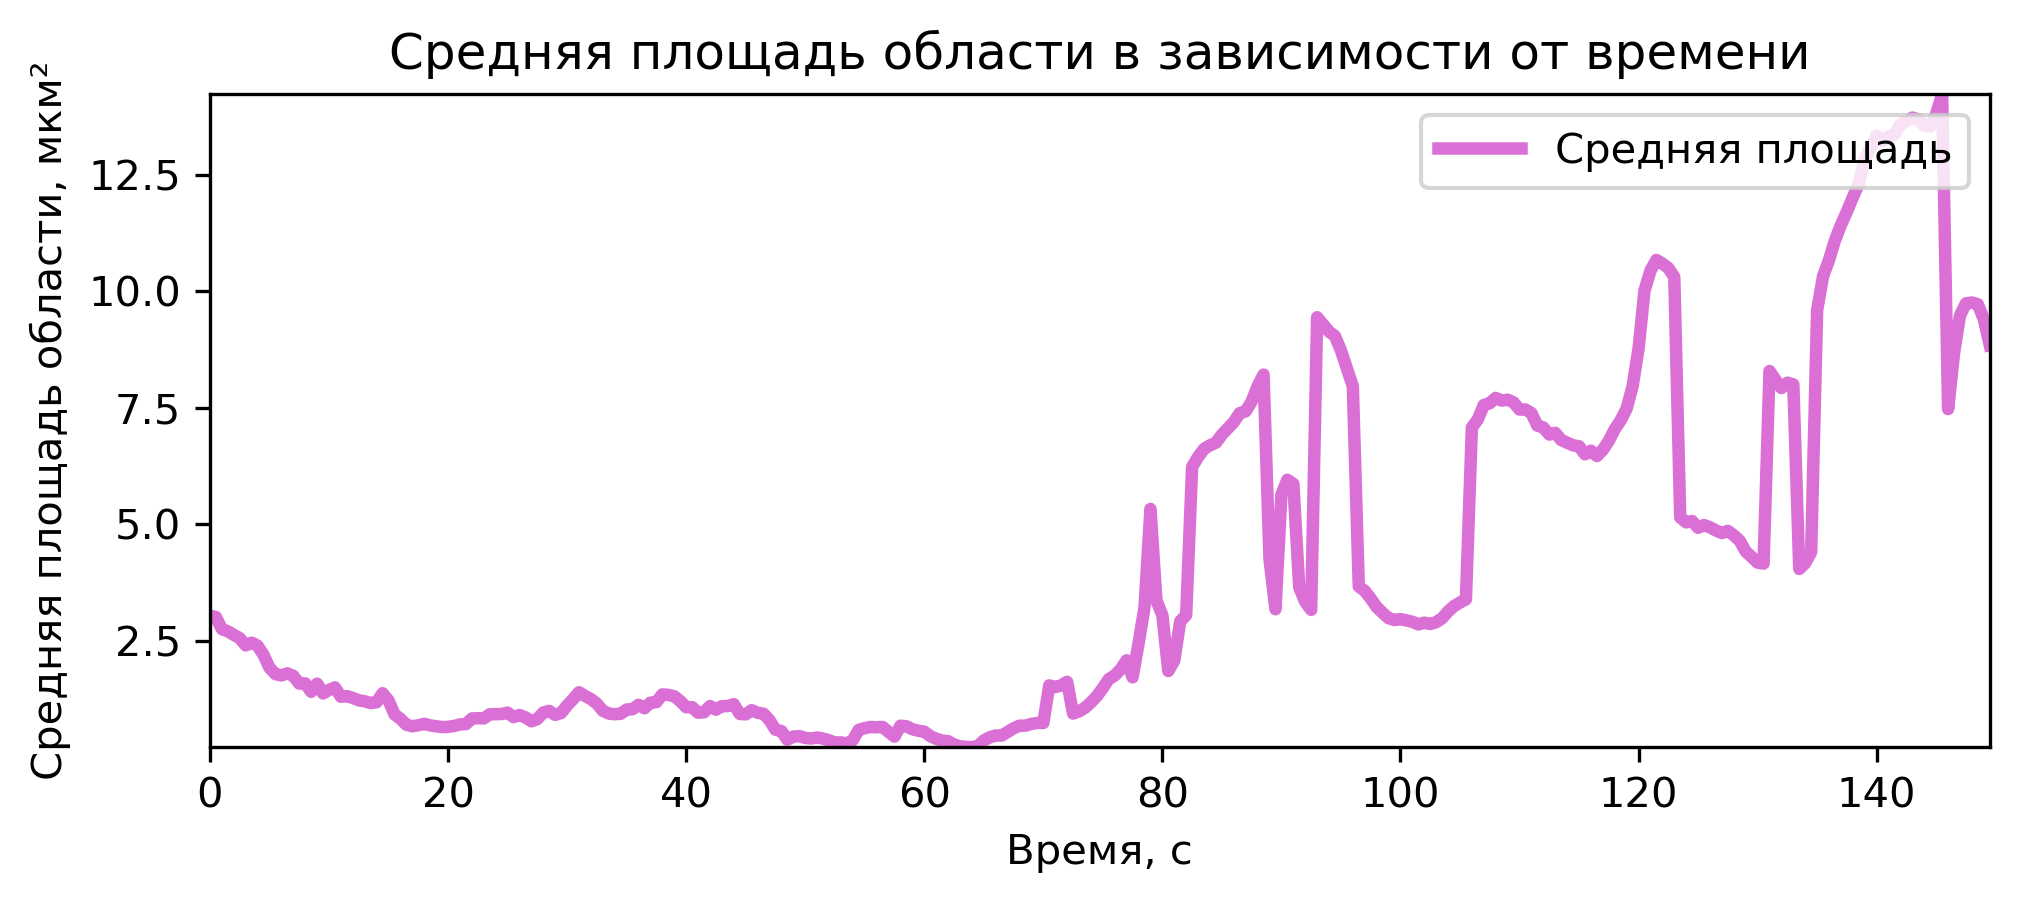

     time_seconds  average_area
0             0.0      3.035815
1             0.5      3.004022
2             1.0      2.746197
3             1.5      2.697452
4             2.0      2.621931
..            ...           ...
295         147.5      9.736640
296         148.0      9.755863
297         148.5      9.717416
298         149.0      9.400231
299         149.5      8.842753

[300 rows x 2 columns]


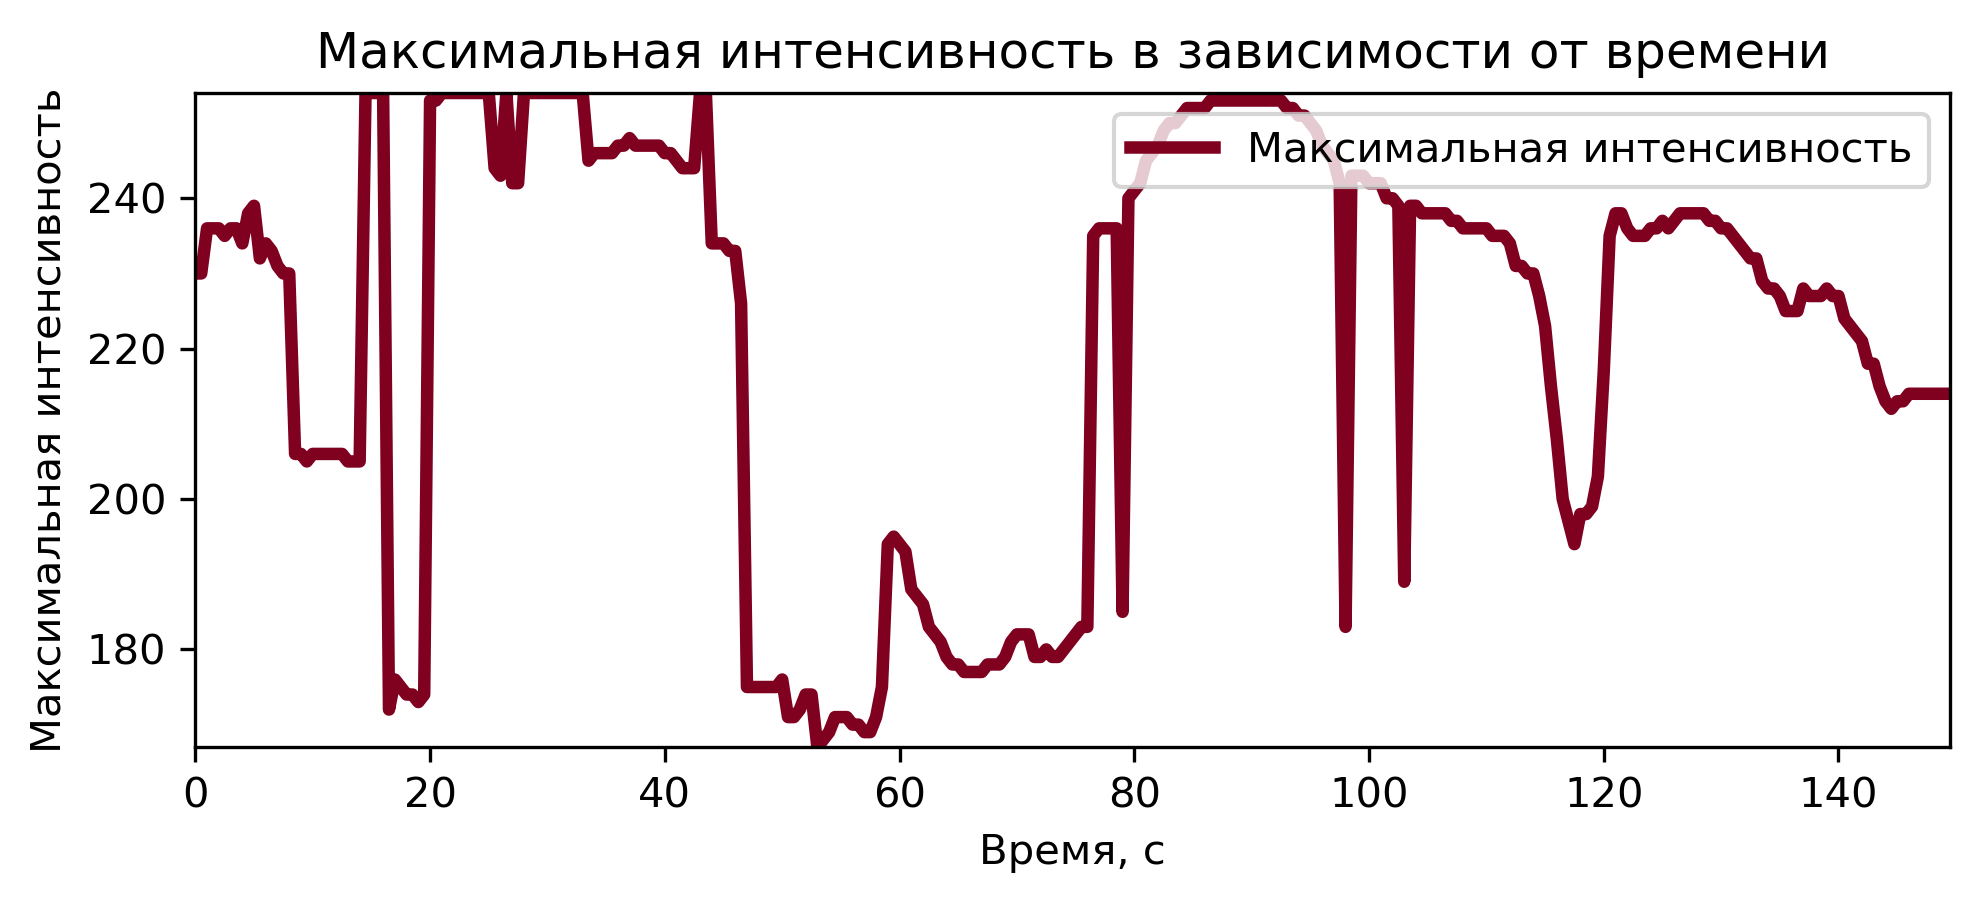

     time_seconds  max_intensity
0             0.0            230
1             0.5            230
2             1.0            236
3             1.5            236
4             2.0            236
..            ...            ...
295         147.5            214
296         148.0            214
297         148.5            214
298         149.0            214
299         149.5            214

[300 rows x 2 columns]


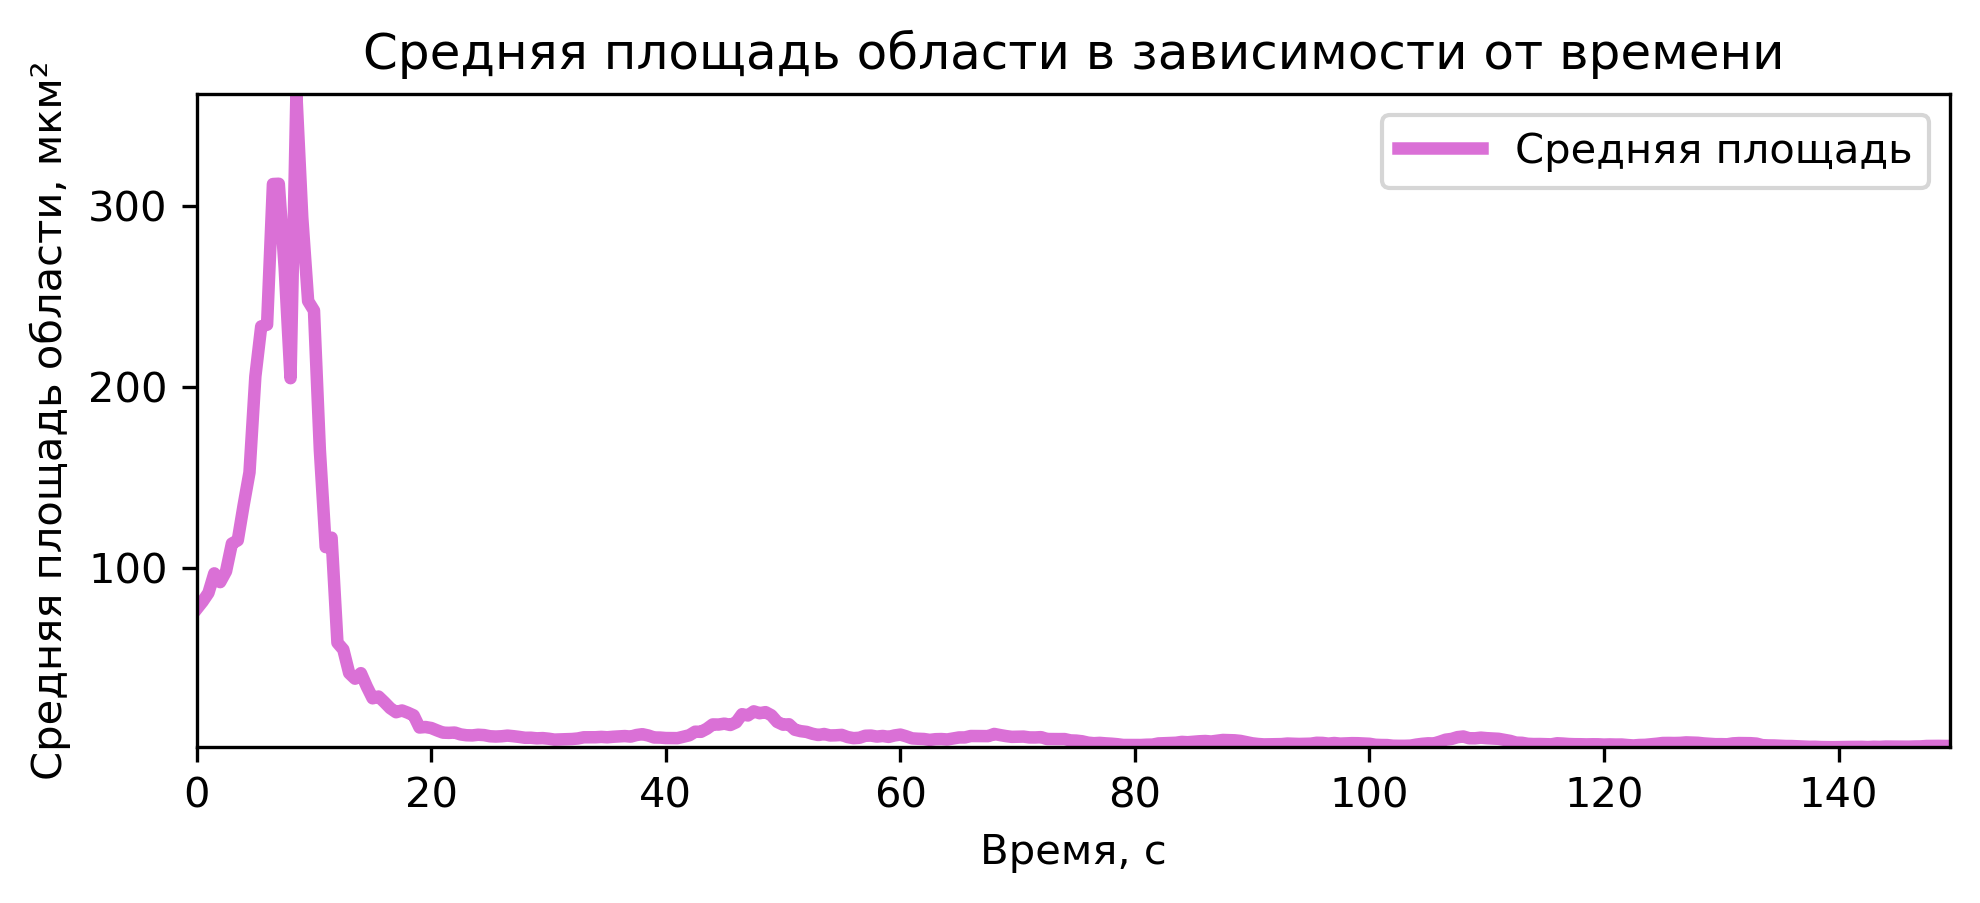

     time_seconds  average_area
0             0.0     77.159884
1             0.5     81.245675
2             1.0     86.038771
3             1.5     96.857543
4             2.0     92.008416
..            ...           ...
295         147.5      1.420782
296         148.0      1.450491
297         148.5      1.473210
298         149.0      1.438258
299         149.5      1.403306

[300 rows x 2 columns]


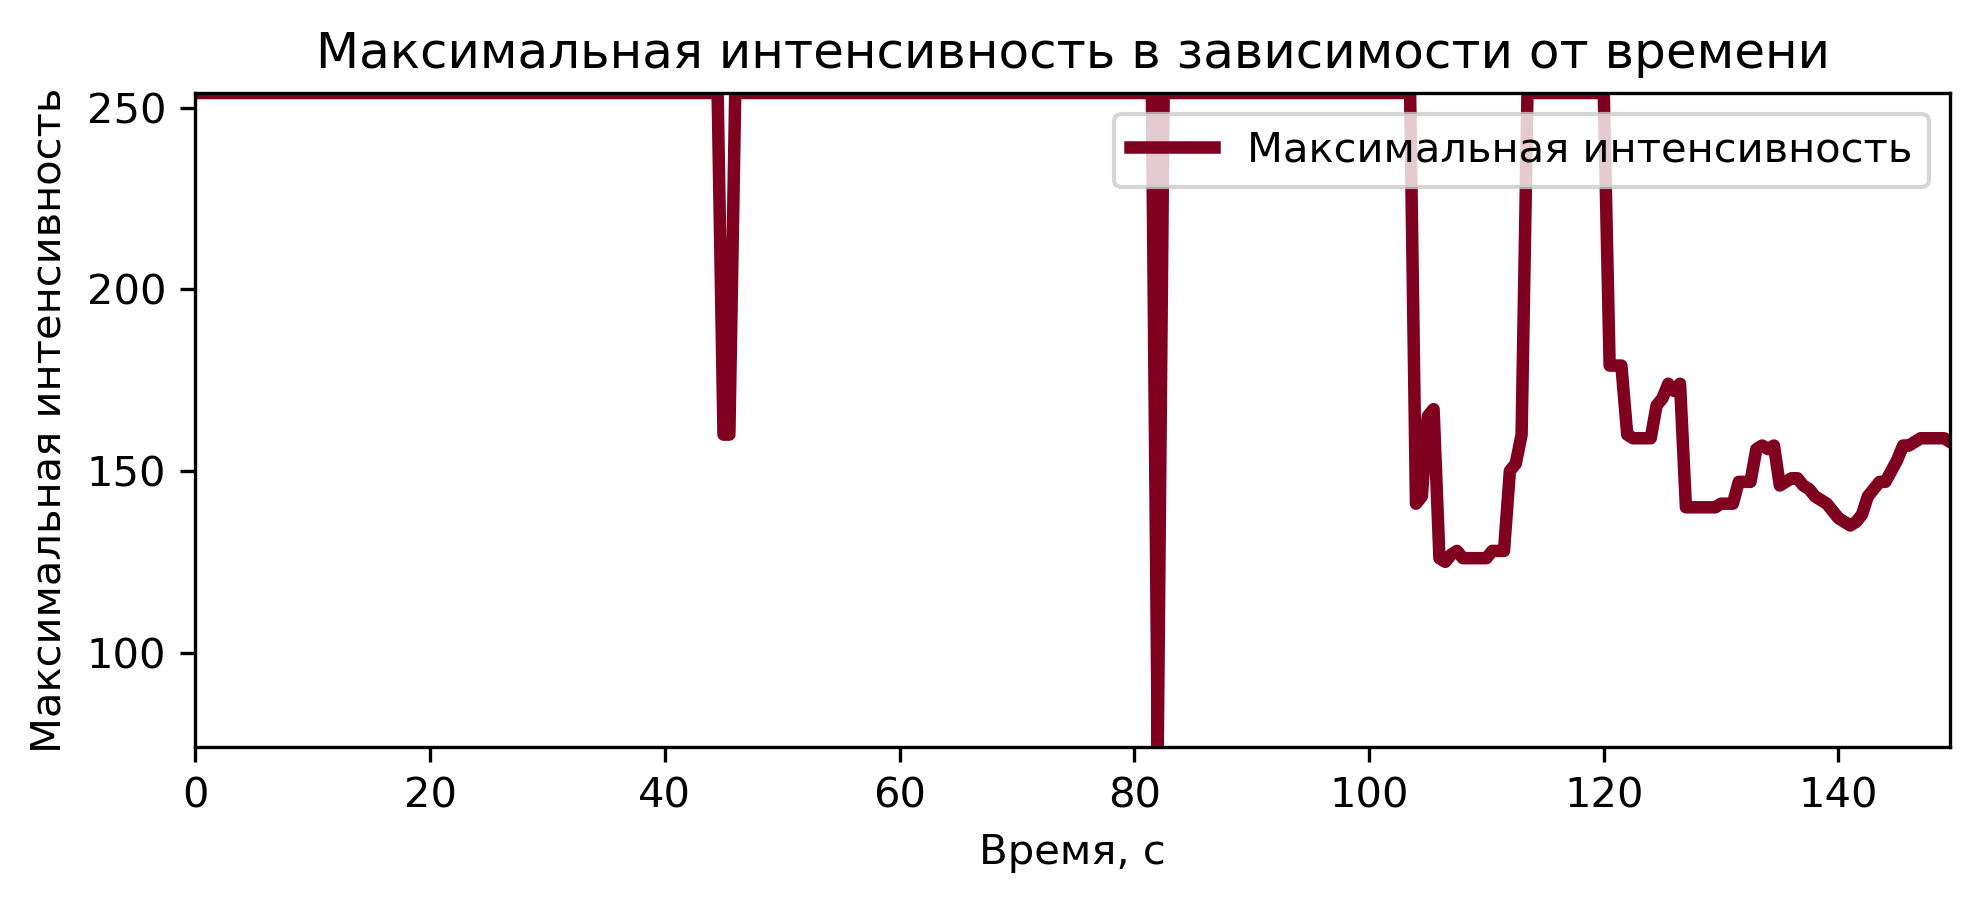

     time_seconds  max_intensity
0             0.0            254
1             0.5            254
2             1.0            254
3             1.5            254
4             2.0            254
..            ...            ...
295         147.5            159
296         148.0            159
297         148.5            159
298         149.0            159
299         149.5            158

[300 rows x 2 columns]


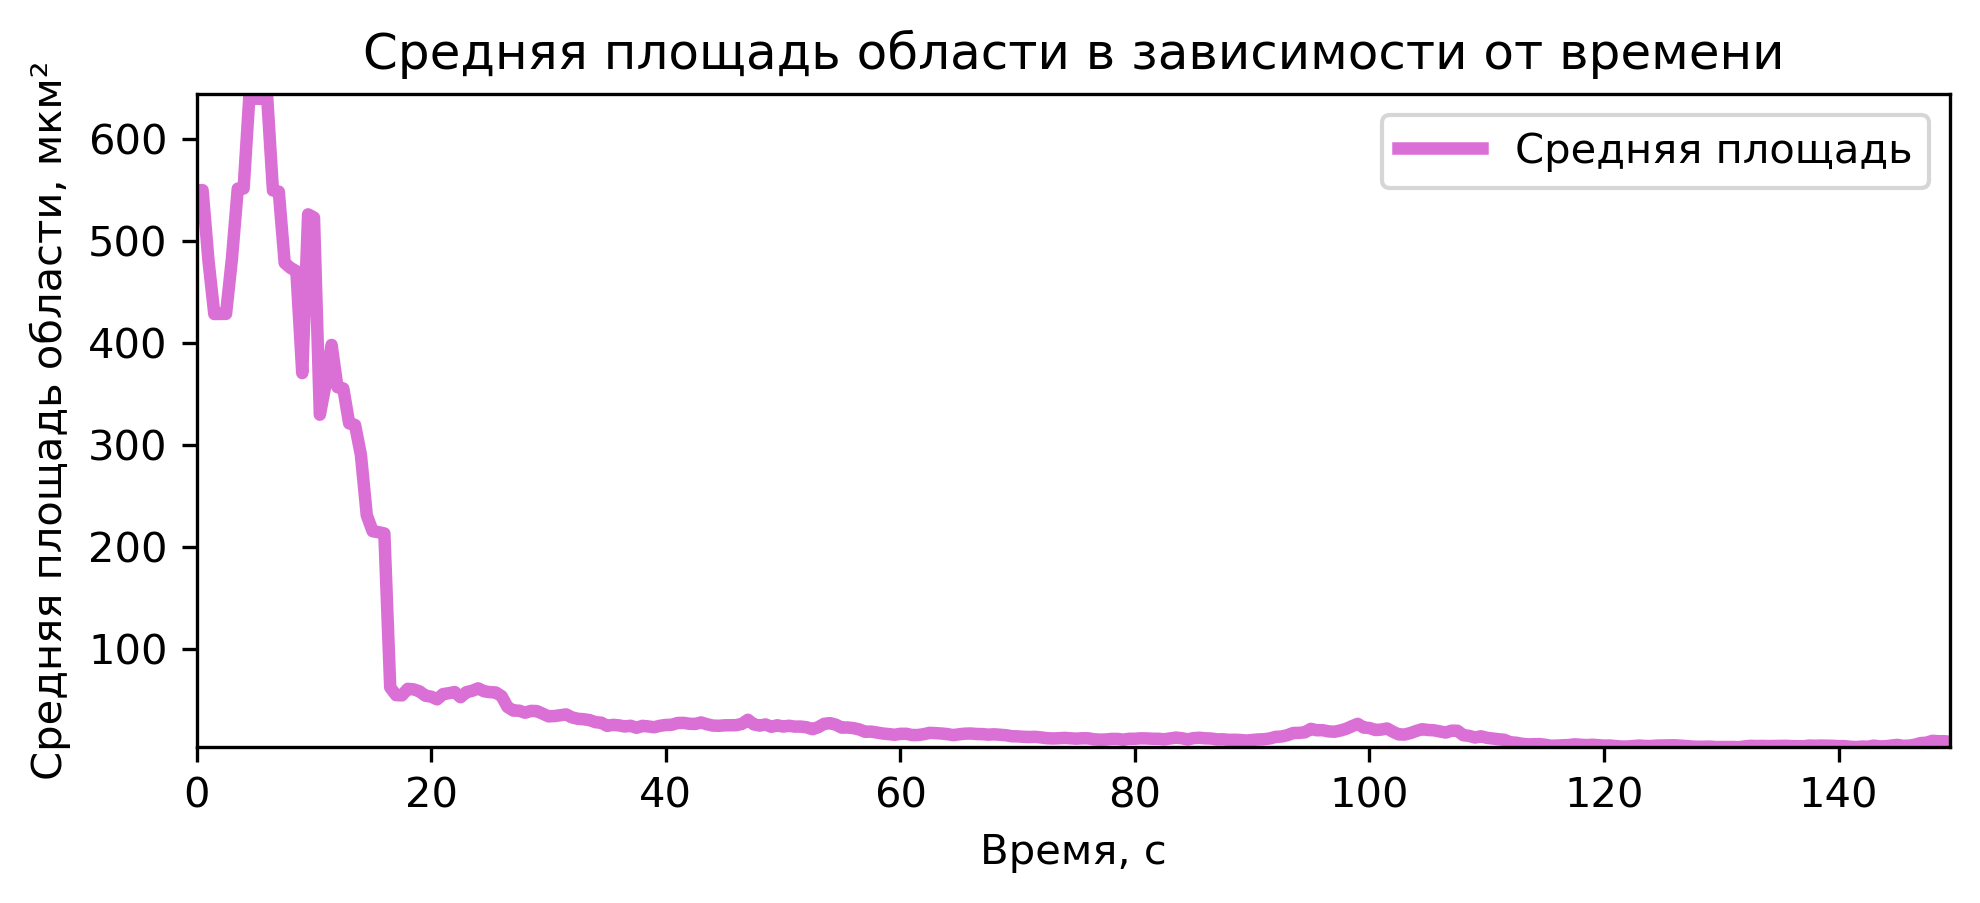

     time_seconds  average_area
0             0.0    549.961553
1             0.5    549.986269
2             1.0    481.271626
3             1.5    428.612927
4             2.0    428.736811
..            ...           ...
295         147.5      8.496732
296         148.0     10.330505
297         148.5      9.894073
298         149.0      9.949470
299         149.5      9.340572

[300 rows x 2 columns]


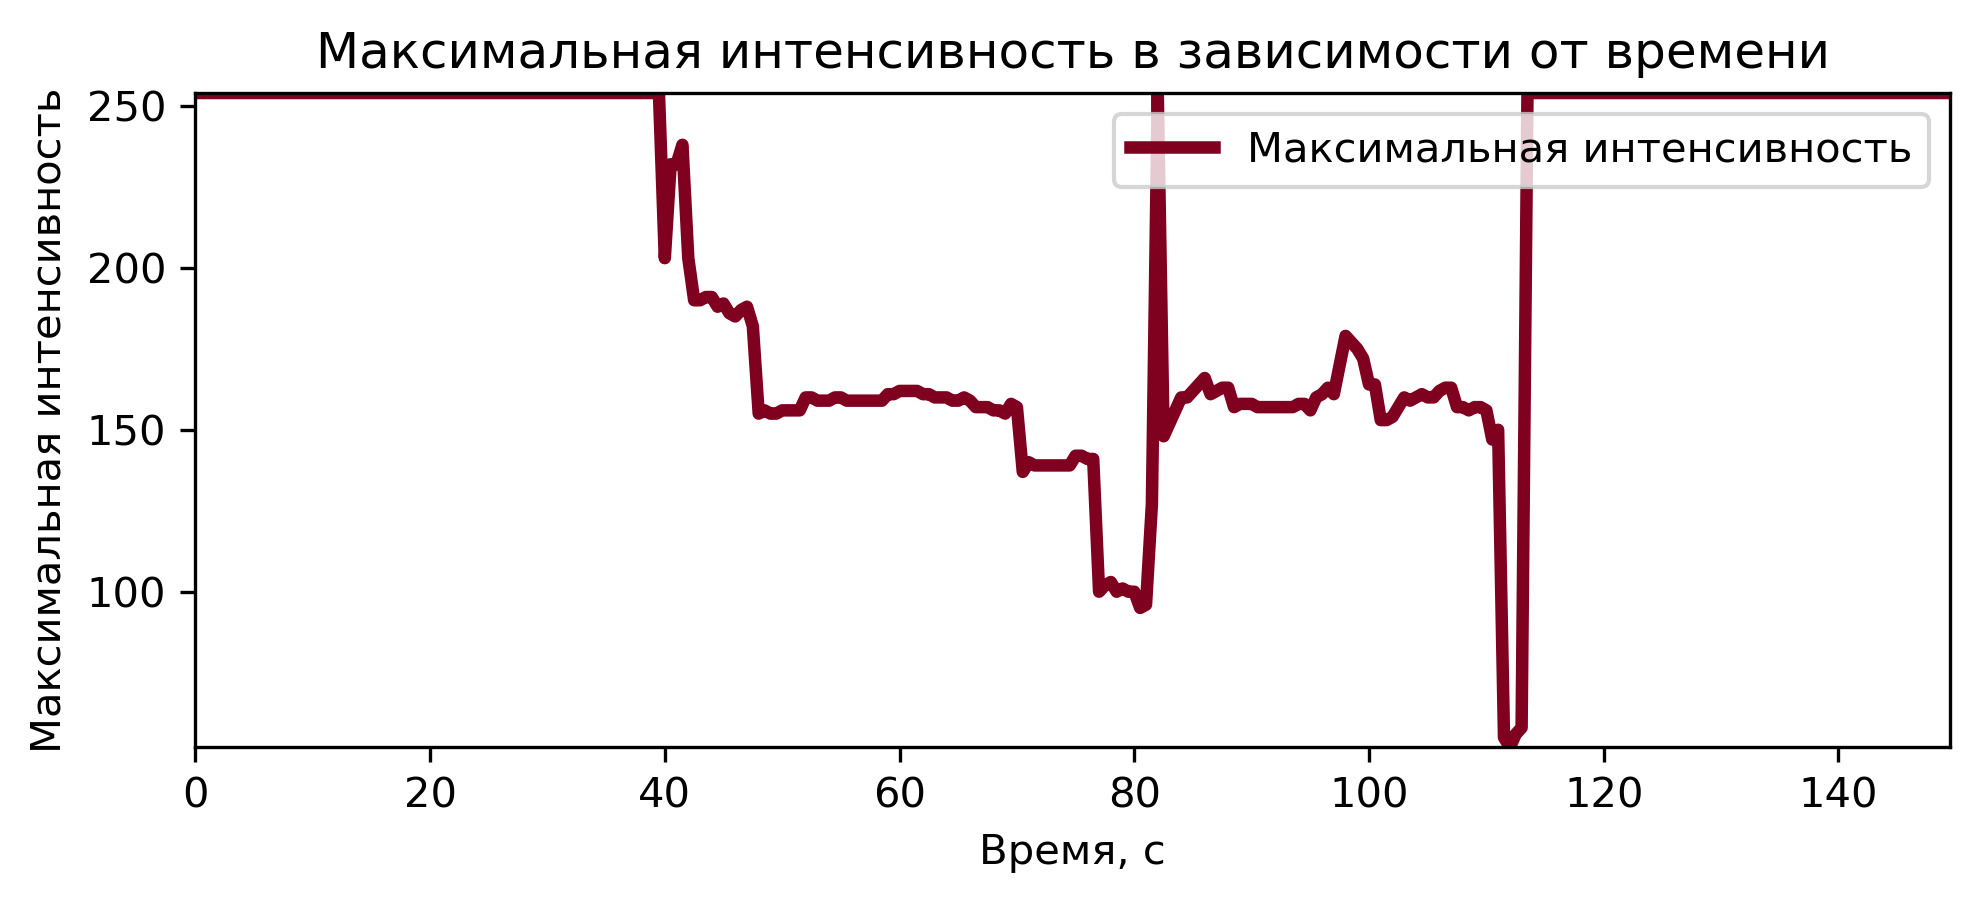

     time_seconds  max_intensity
0             0.0            254
1             0.5            254
2             1.0            254
3             1.5            254
4             2.0            254
..            ...            ...
295         147.5            254
296         148.0            254
297         148.5            254
298         149.0            254
299         149.5            254

[300 rows x 2 columns]


In [ ]:
main_folder_path = r'C:\Users\Vector\Desktop\Final\General'
function_runs_all_functions(main_folder_path)

### Запуск функции с помощью модуля

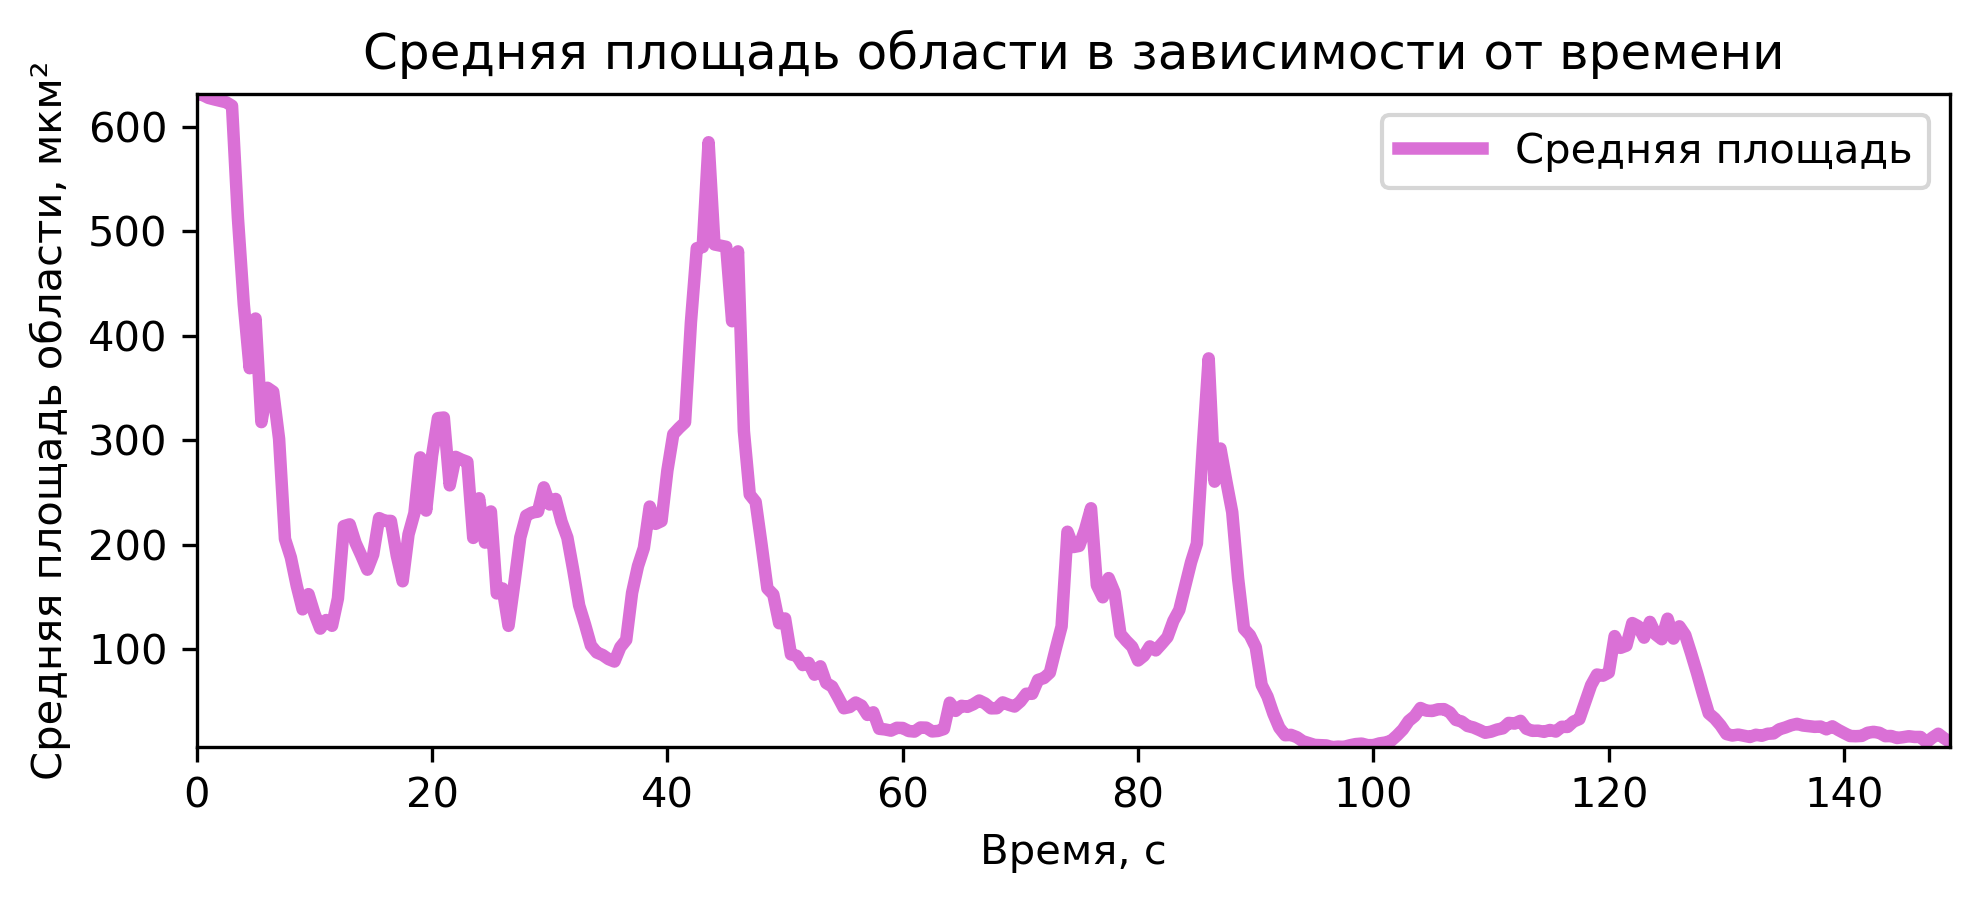

     time_seconds  average_area
0             0.0    631.268743
1             0.5    630.630527
2             1.0    627.812380
3             1.5    626.339869
4             2.0    625.017301
..            ...           ...
294         147.0     10.946339
295         147.5     15.502135
296         148.0     19.225939
297         148.5     14.901151
298         149.0     11.397860

[299 rows x 2 columns]


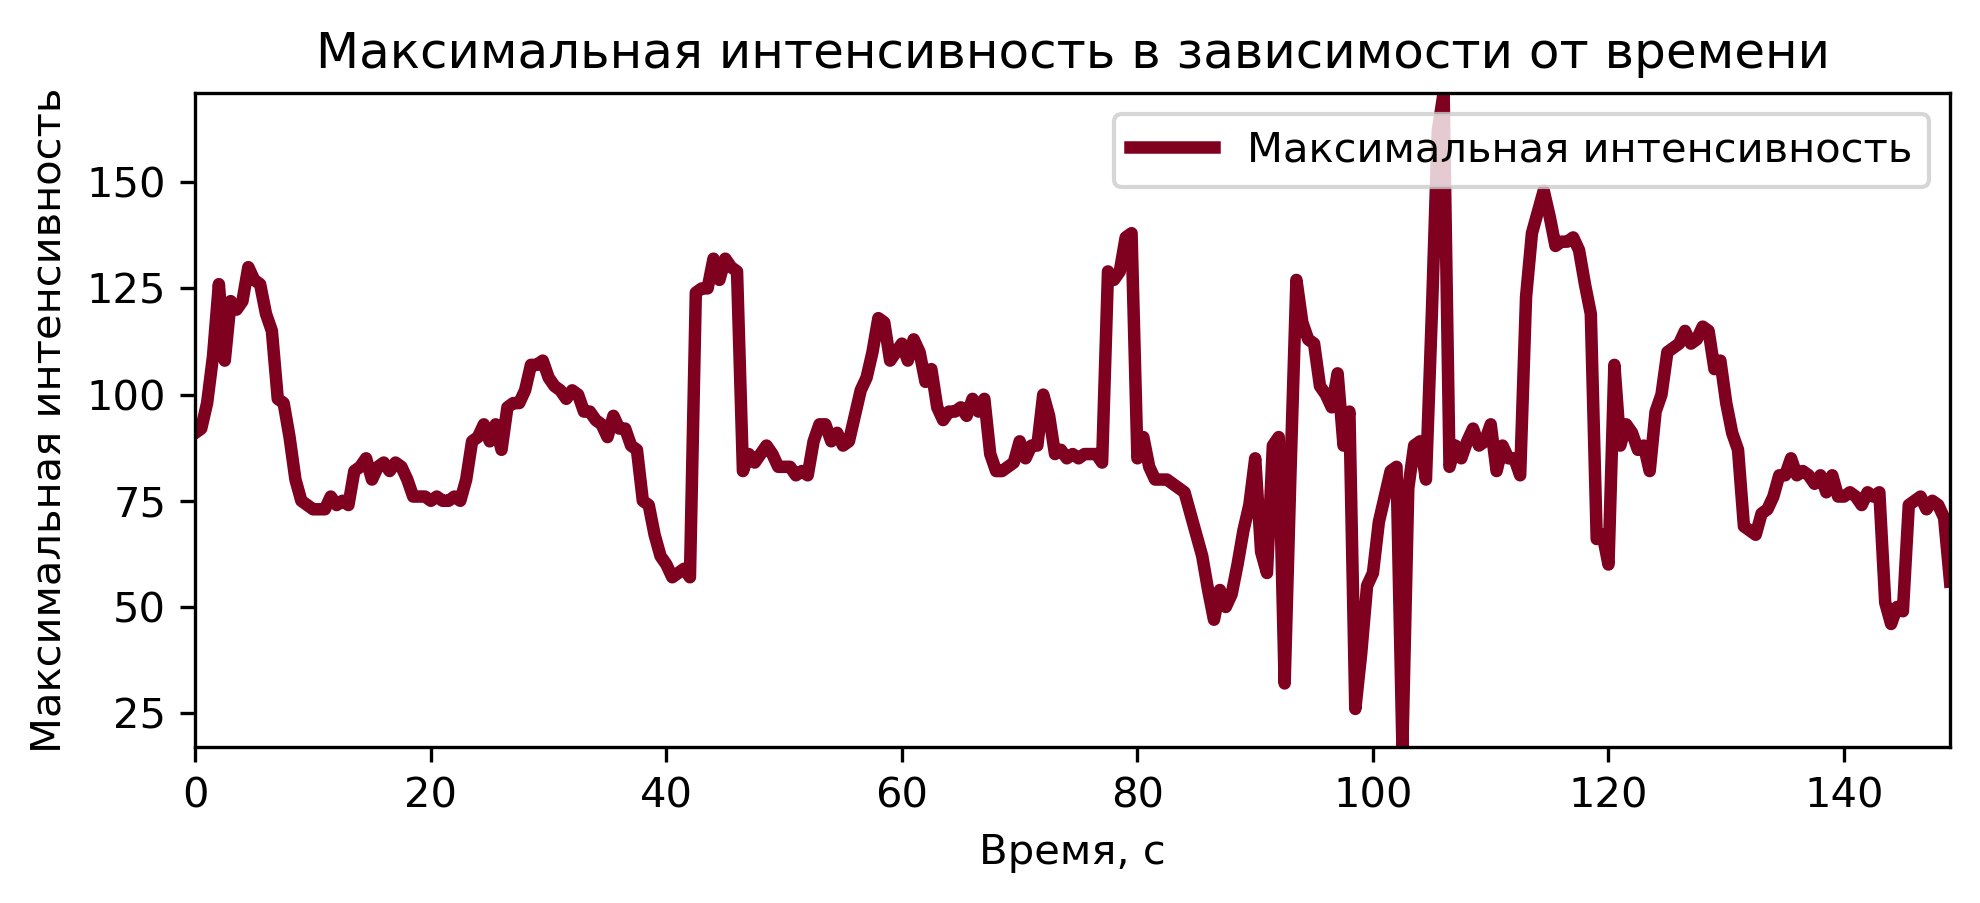

     time_seconds  max_intensity
0             0.0             91
1             0.5             92
2             1.0             98
3             1.5            109
4             2.0            126
..            ...            ...
294         147.0             73
295         147.5             75
296         148.0             74
297         148.5             71
298         149.0             56

[299 rows x 2 columns]


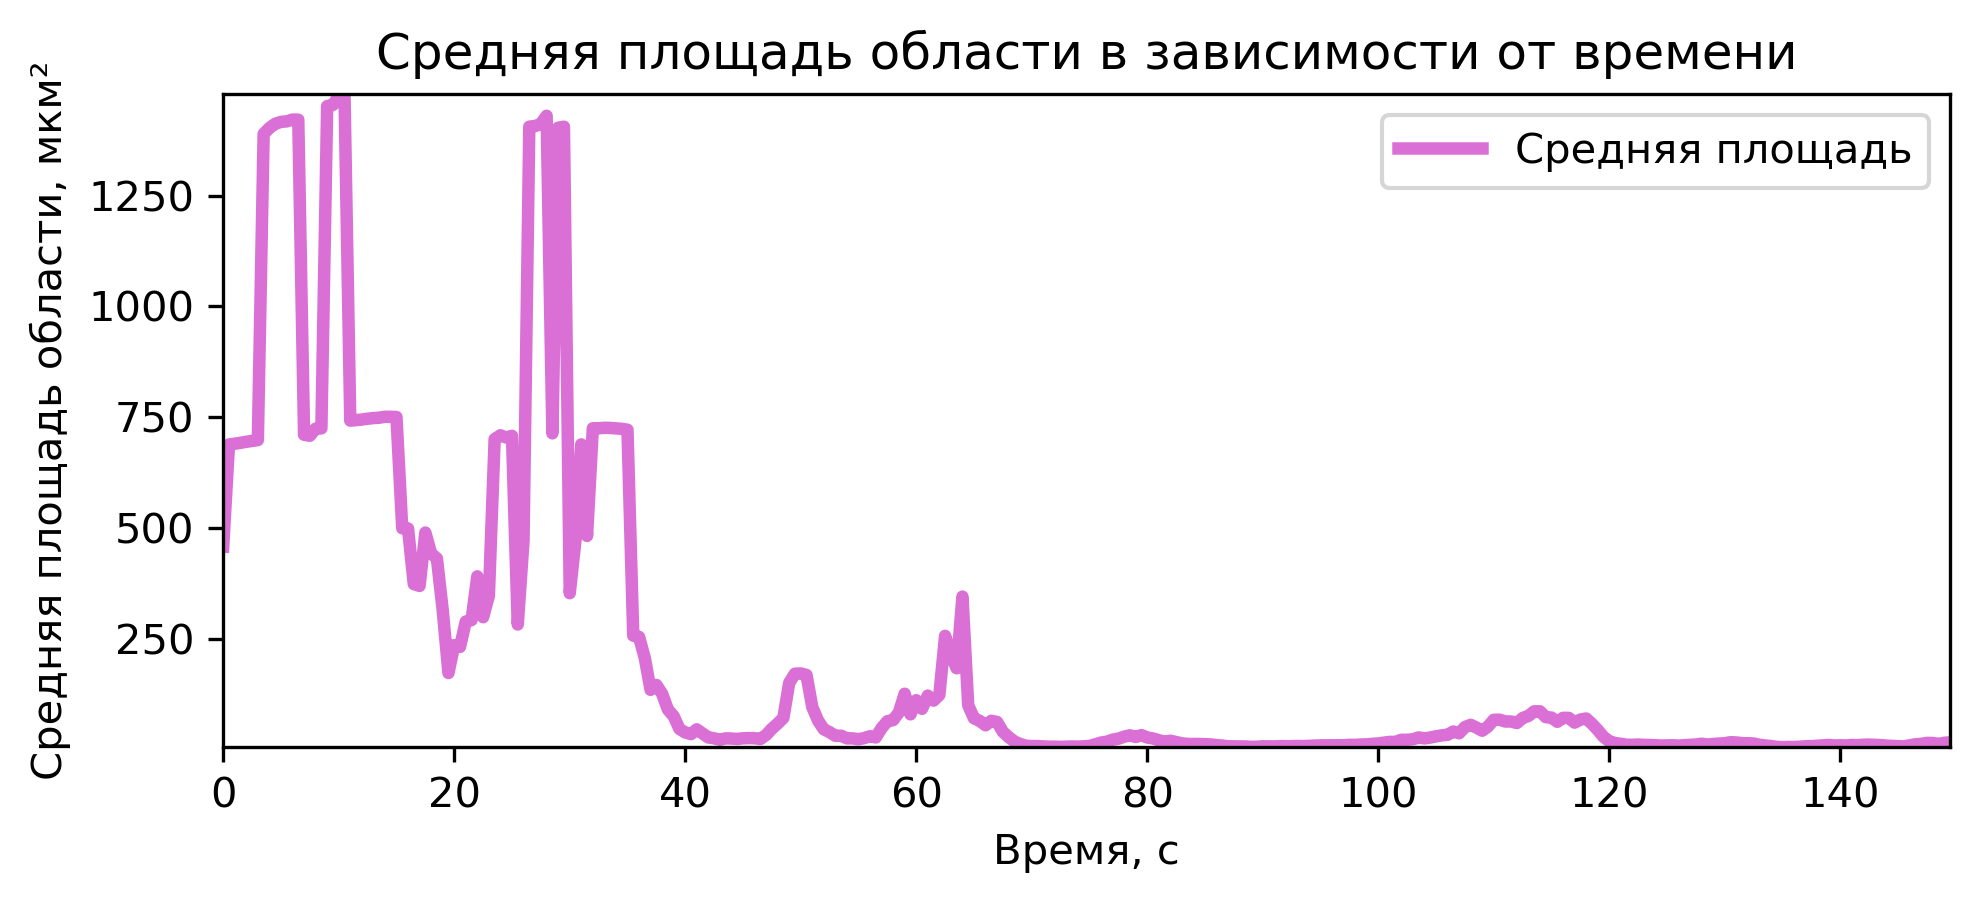

     time_seconds  average_area
0             0.0    458.592849
1             0.5    688.840830
2             1.0    690.522876
3             1.5    692.579777
4             2.0    694.934641
..            ...           ...
295         147.5     16.033577
296         148.0     15.796809
297         148.5     13.786196
298         149.0     16.220006
299         149.5     17.155167

[300 rows x 2 columns]


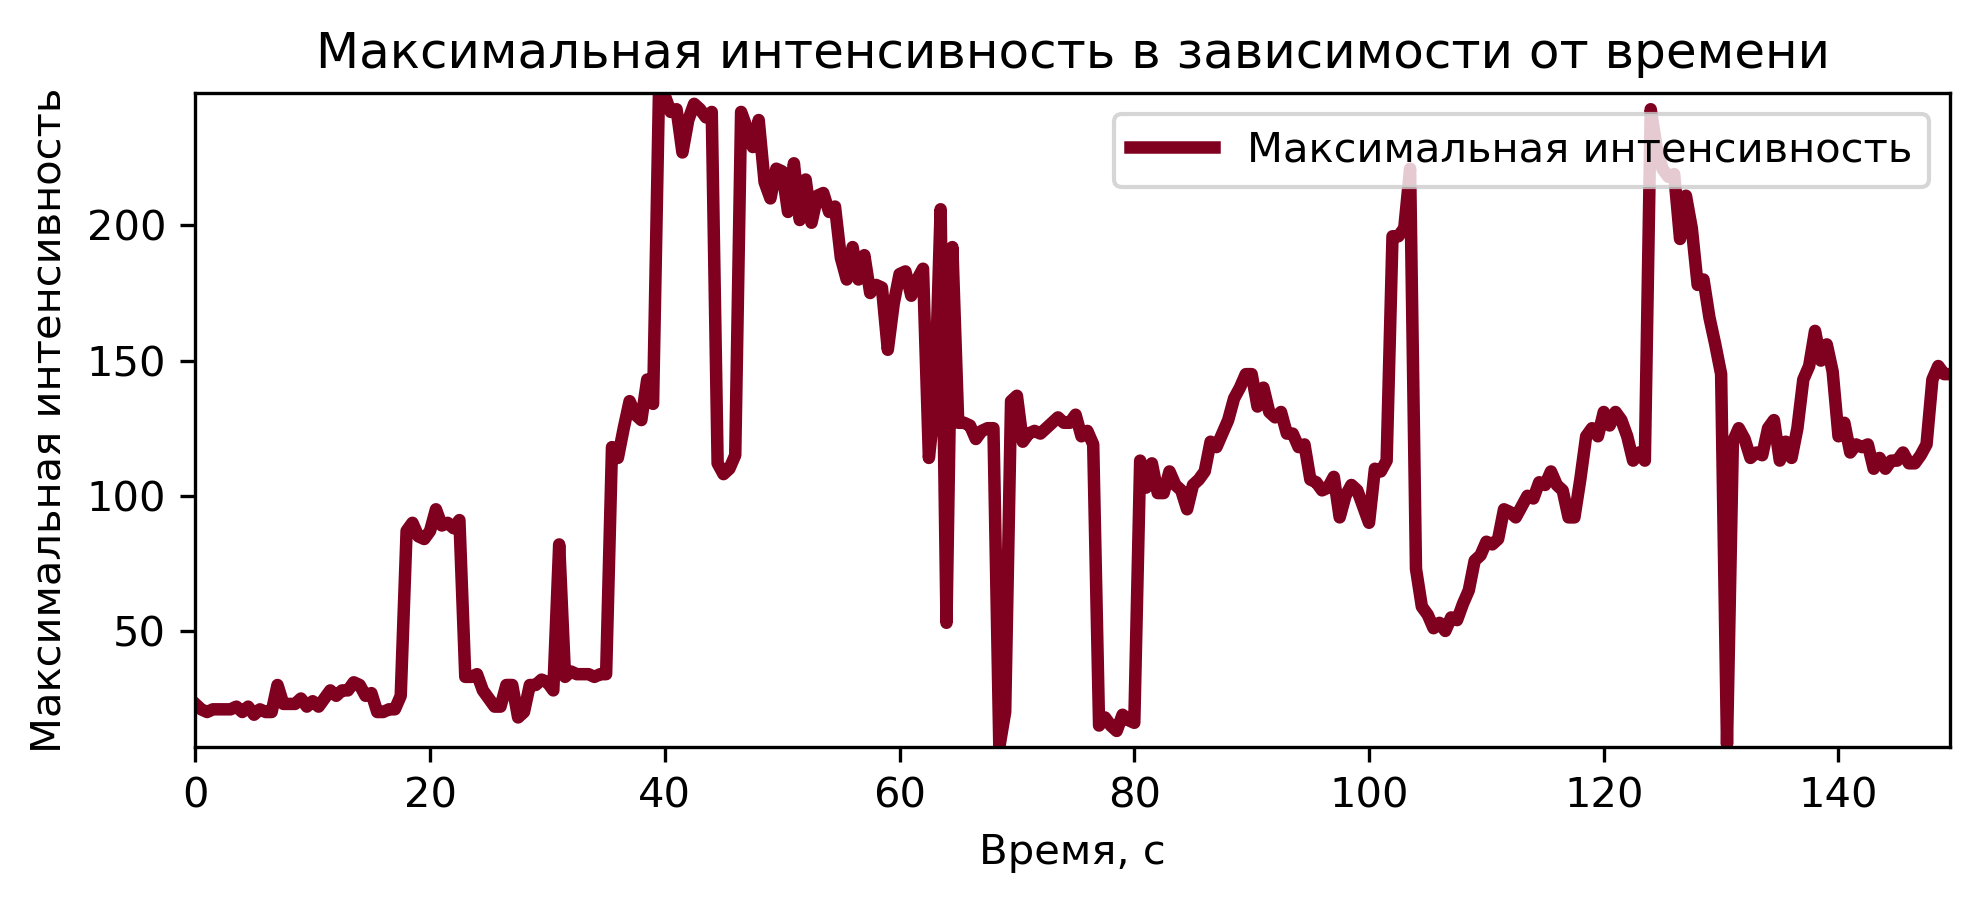

     time_seconds  max_intensity
0             0.0             23
1             0.5             21
2             1.0             20
3             1.5             21
4             2.0             21
..            ...            ...
295         147.5            119
296         148.0            143
297         148.5            148
298         149.0            145
299         149.5            145

[300 rows x 2 columns]


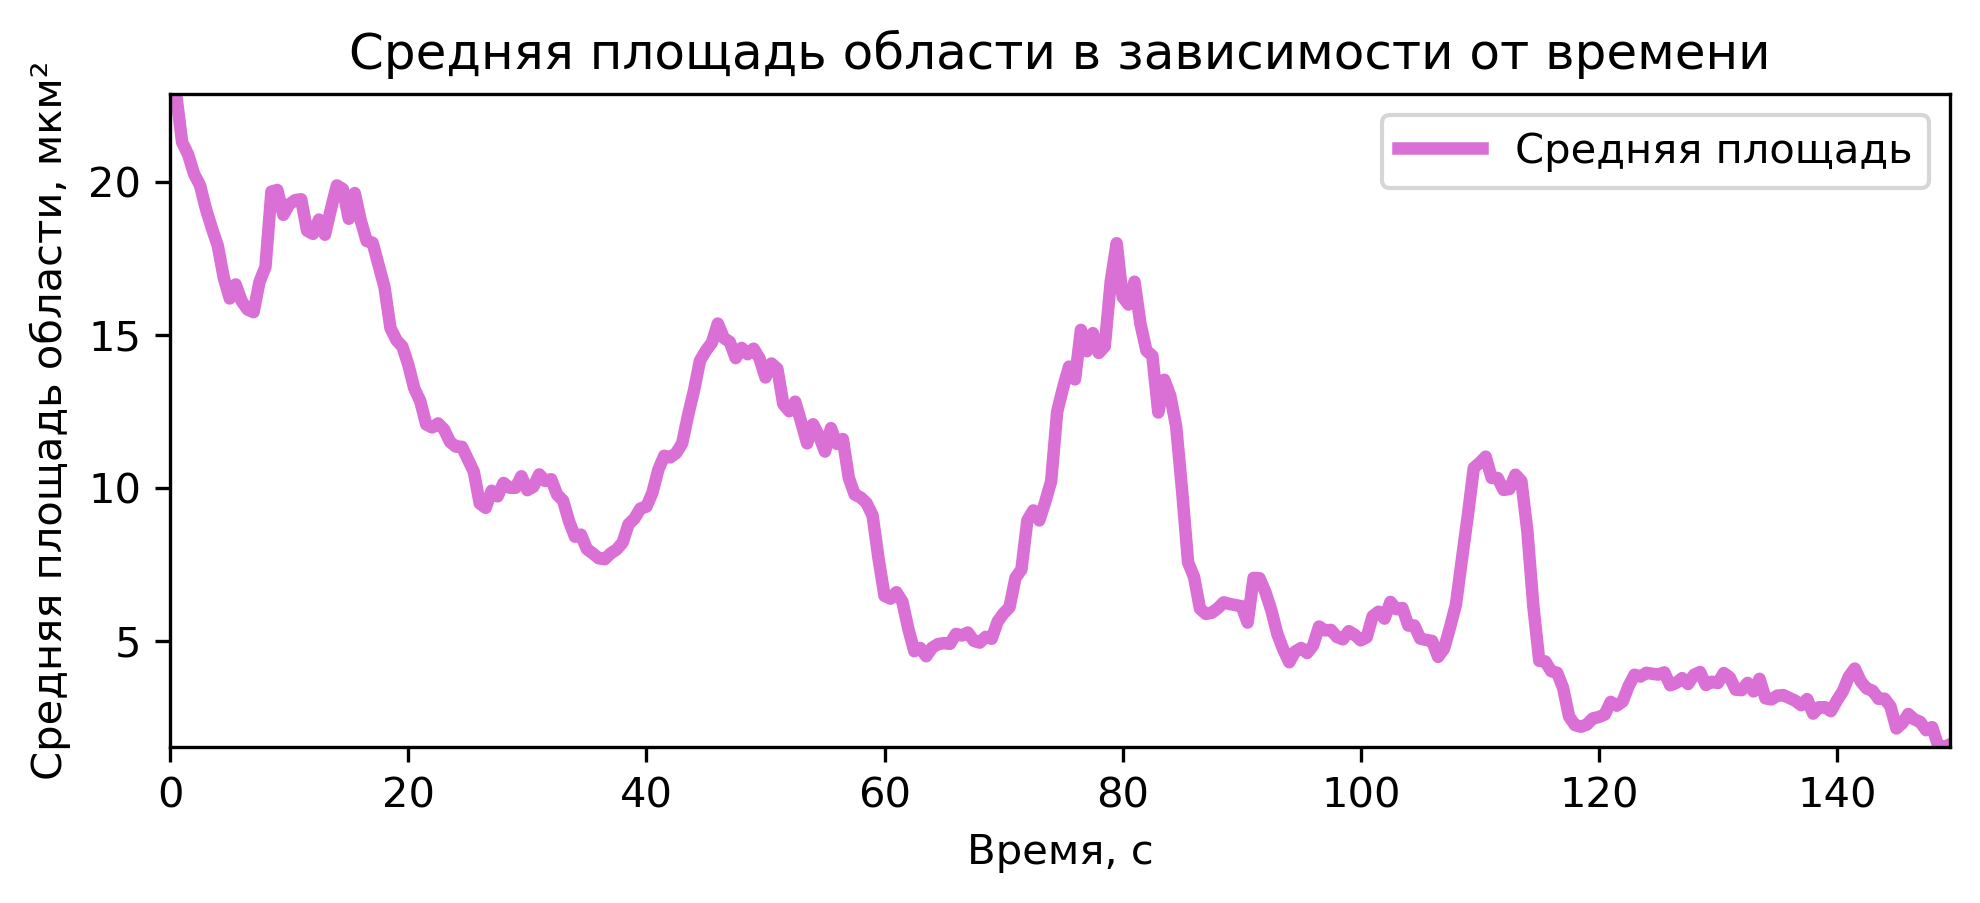

     time_seconds  average_area
0             0.0     22.645400
1             0.5     22.871812
2             1.0     21.304493
3             1.5     20.907886
4             2.0     20.272972
..            ...           ...
295         147.5      2.089196
296         148.0      2.190549
297         148.5      1.594704
298         149.0      1.536039
299         149.5      1.628928

[300 rows x 2 columns]


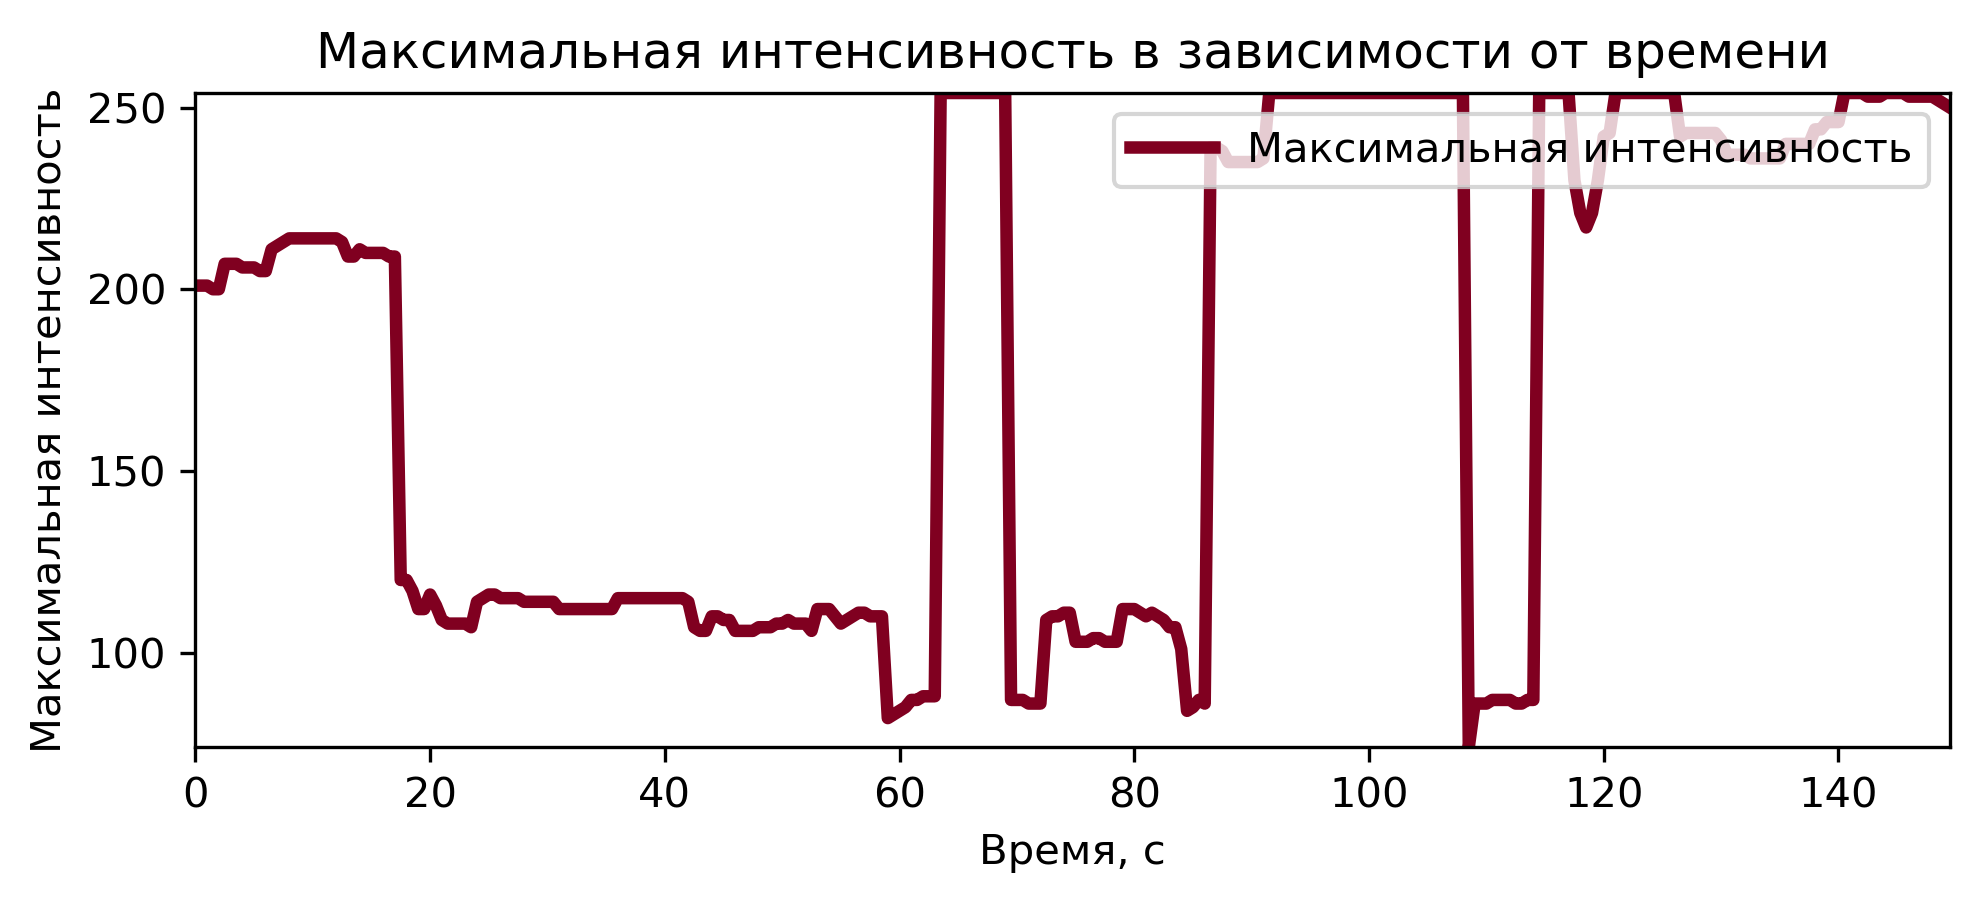

     time_seconds  max_intensity
0             0.0            201
1             0.5            201
2             1.0            201
3             1.5            200
4             2.0            200
..            ...            ...
295         147.5            253
296         148.0            253
297         148.5            252
298         149.0            251
299         149.5            250

[300 rows x 2 columns]


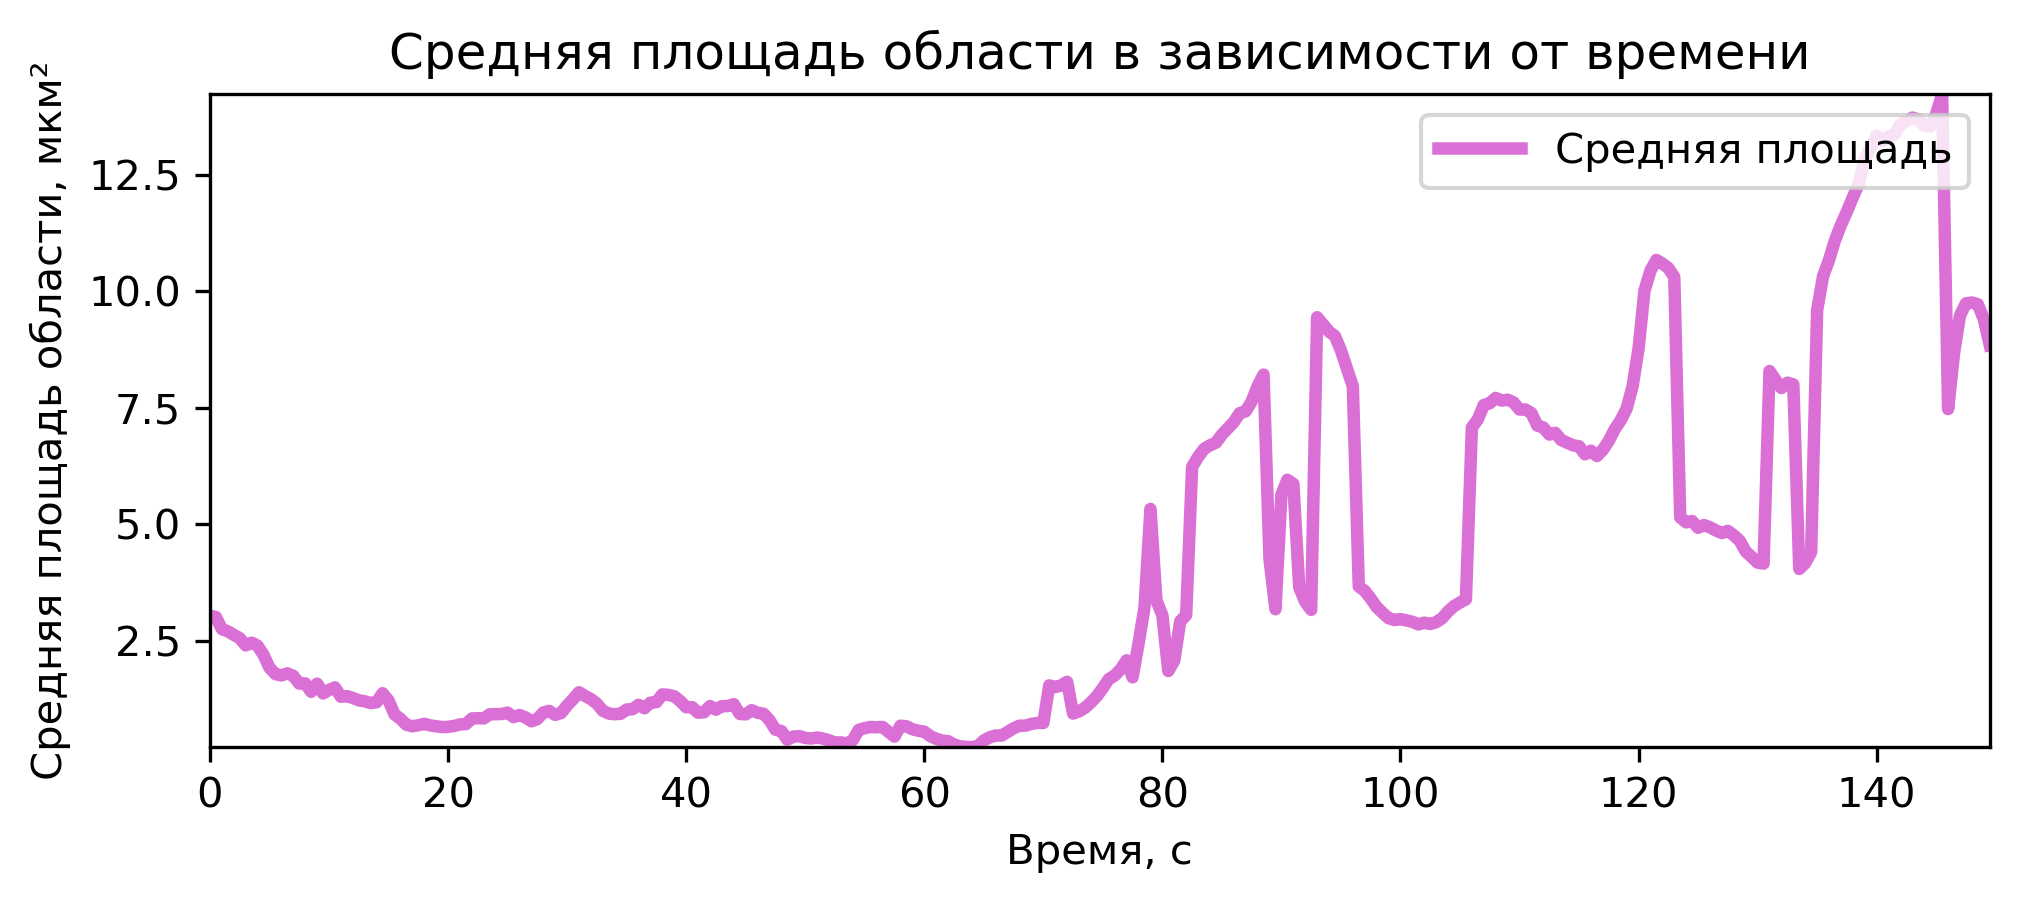

     time_seconds  average_area
0             0.0      3.035815
1             0.5      3.004022
2             1.0      2.746197
3             1.5      2.697452
4             2.0      2.621931
..            ...           ...
295         147.5      9.736640
296         148.0      9.755863
297         148.5      9.717416
298         149.0      9.400231
299         149.5      8.842753

[300 rows x 2 columns]


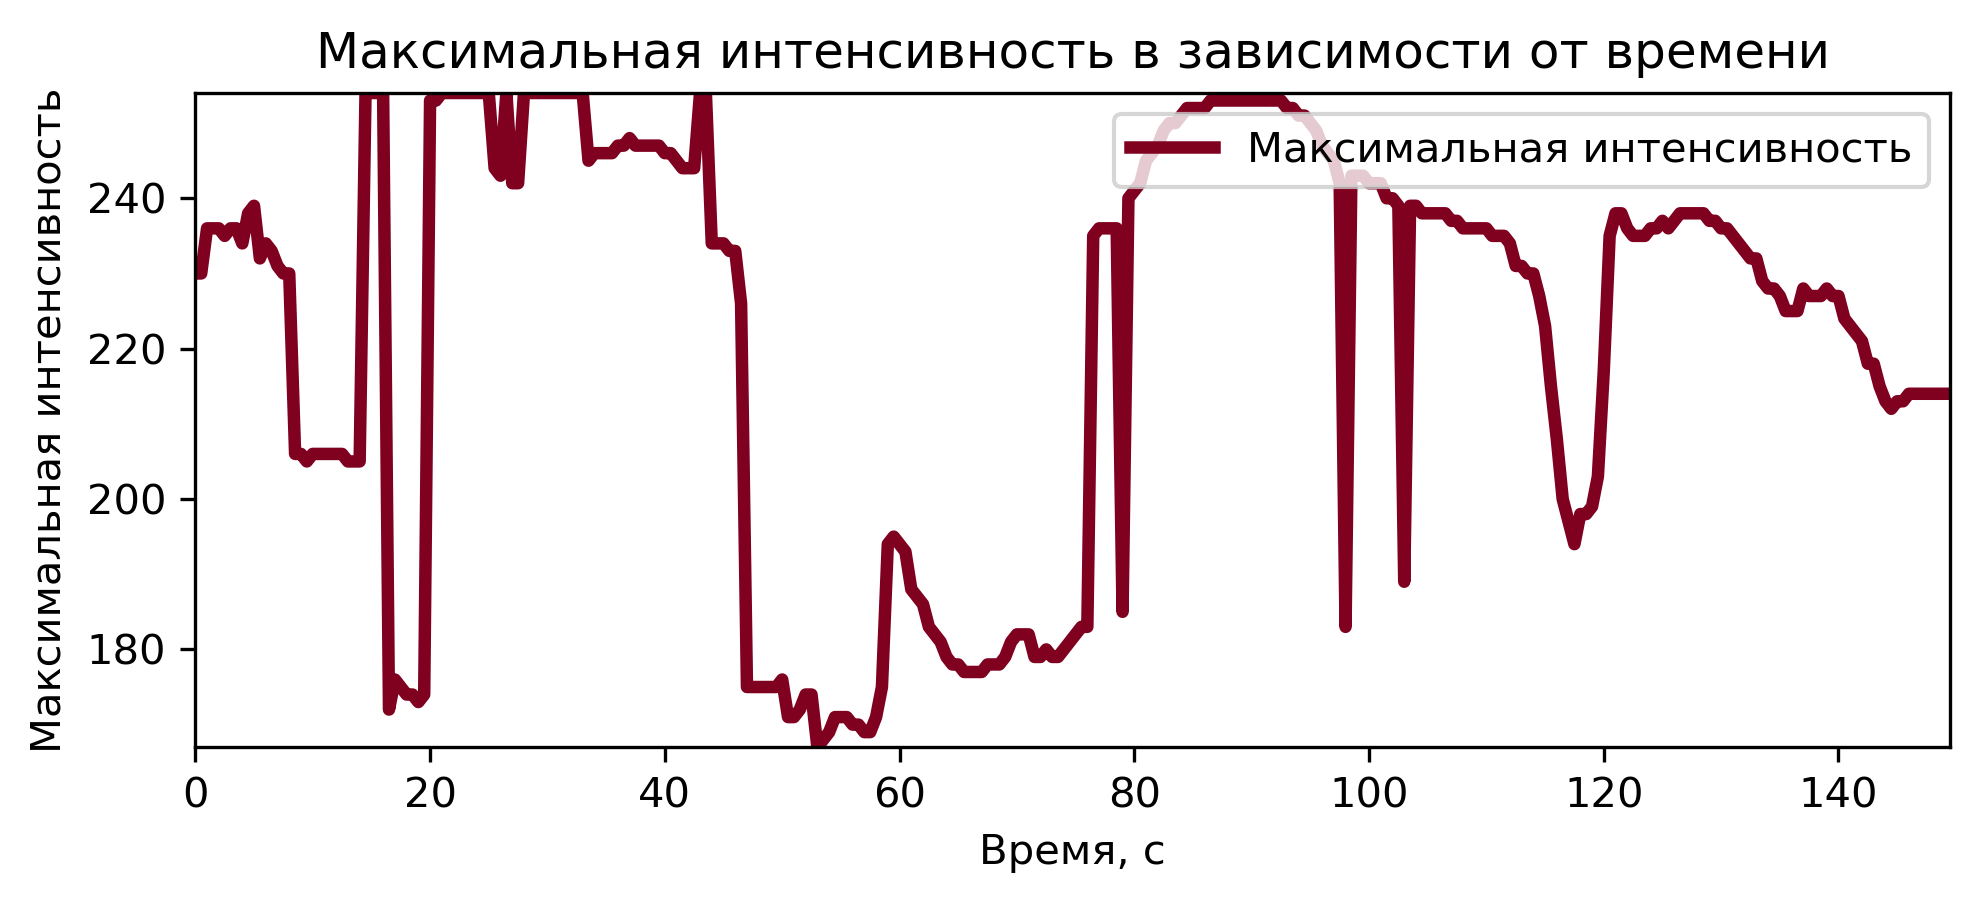

     time_seconds  max_intensity
0             0.0            230
1             0.5            230
2             1.0            236
3             1.5            236
4             2.0            236
..            ...            ...
295         147.5            214
296         148.0            214
297         148.5            214
298         149.0            214
299         149.5            214

[300 rows x 2 columns]


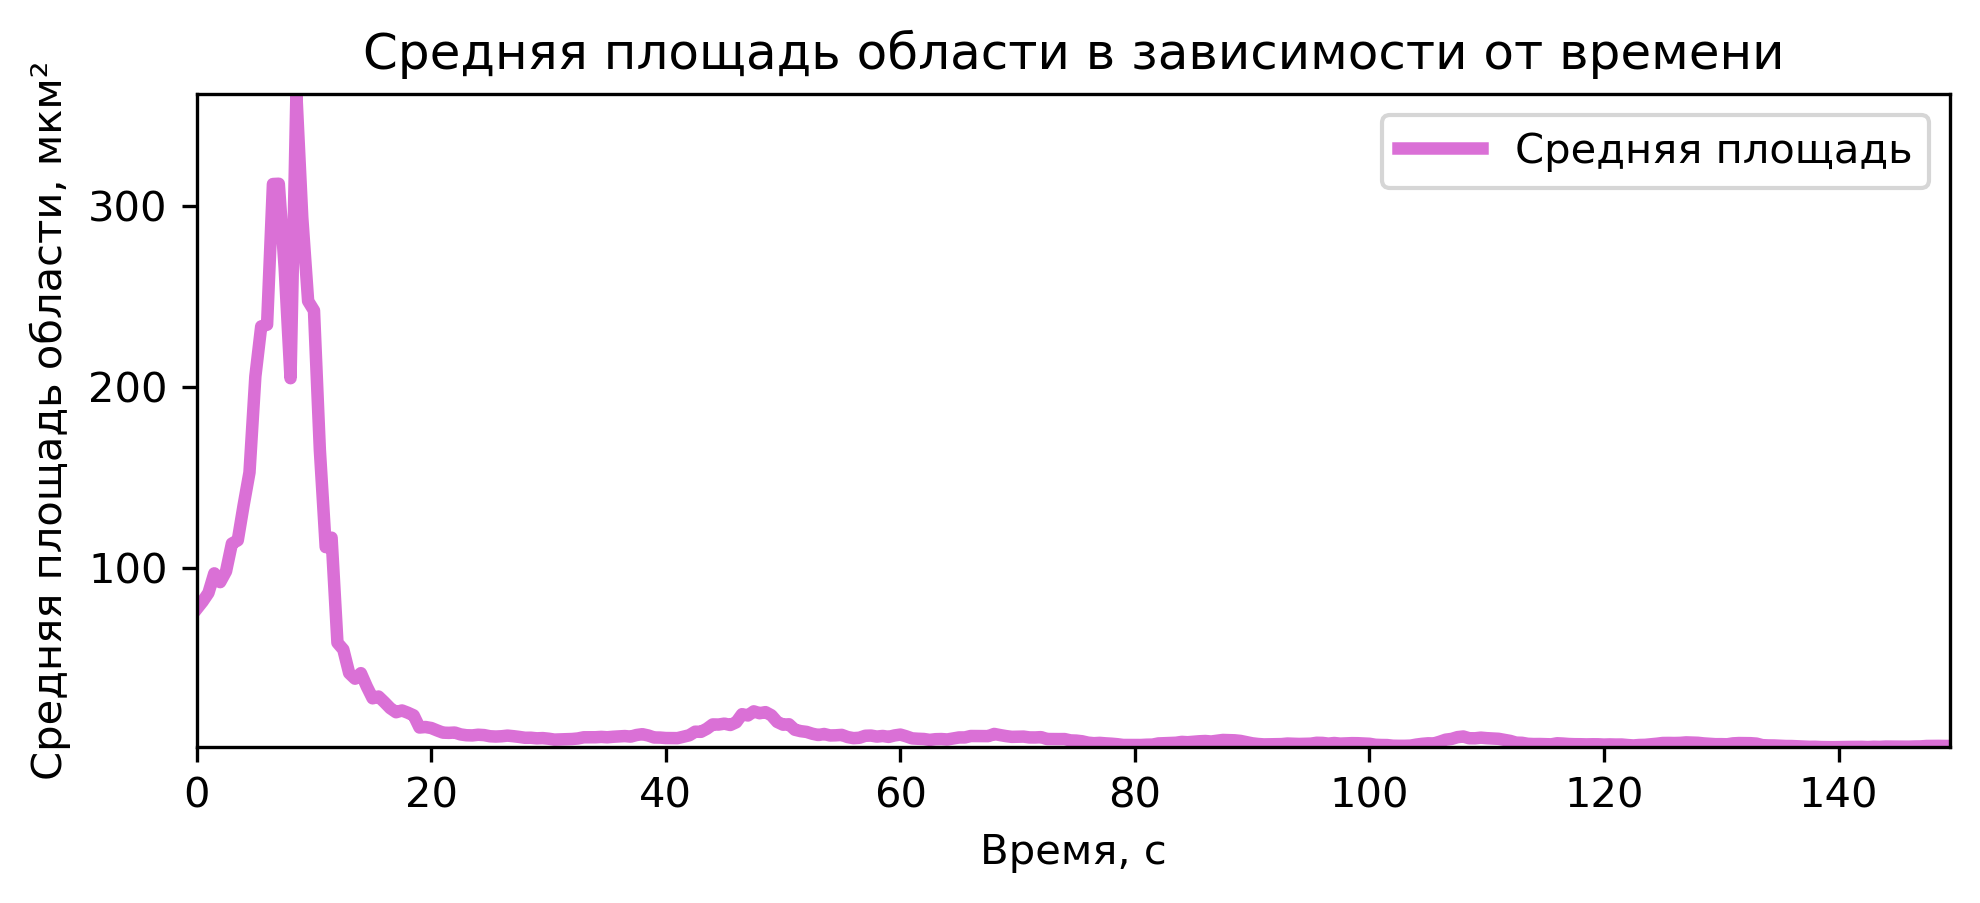

     time_seconds  average_area
0             0.0     77.159884
1             0.5     81.245675
2             1.0     86.038771
3             1.5     96.857543
4             2.0     92.008416
..            ...           ...
295         147.5      1.420782
296         148.0      1.450491
297         148.5      1.473210
298         149.0      1.438258
299         149.5      1.403306

[300 rows x 2 columns]


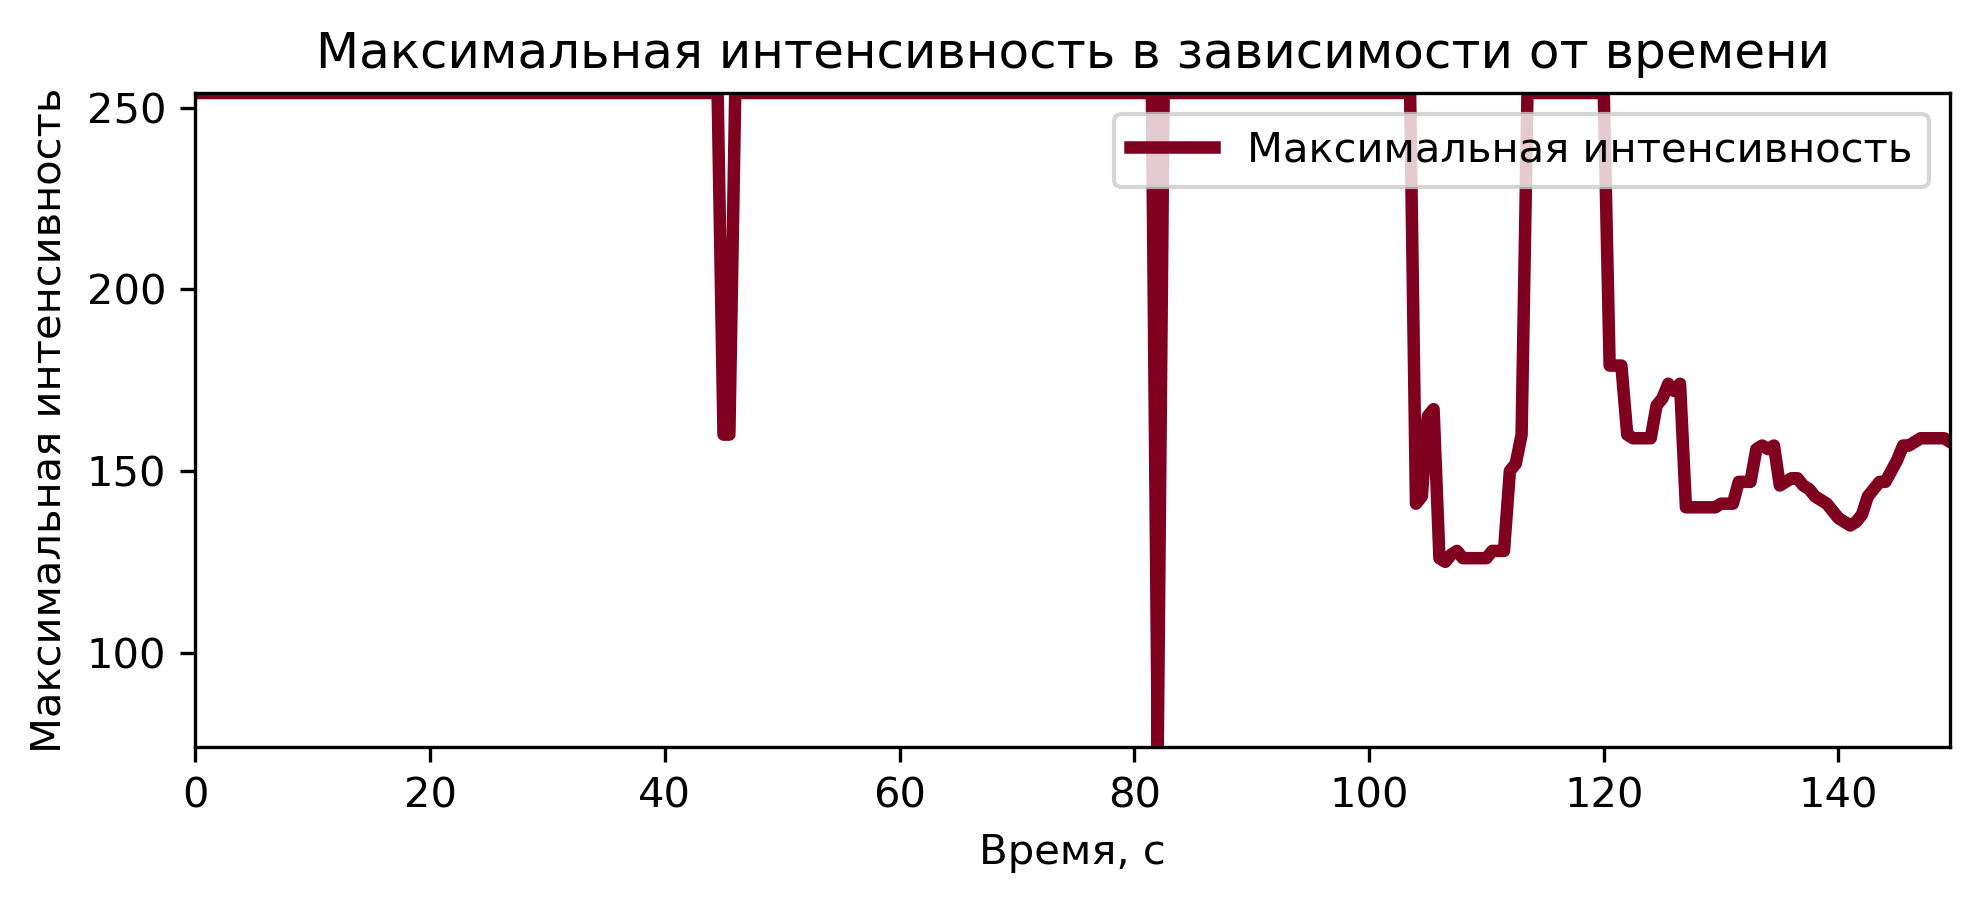

     time_seconds  max_intensity
0             0.0            254
1             0.5            254
2             1.0            254
3             1.5            254
4             2.0            254
..            ...            ...
295         147.5            159
296         148.0            159
297         148.5            159
298         149.0            159
299         149.5            158

[300 rows x 2 columns]


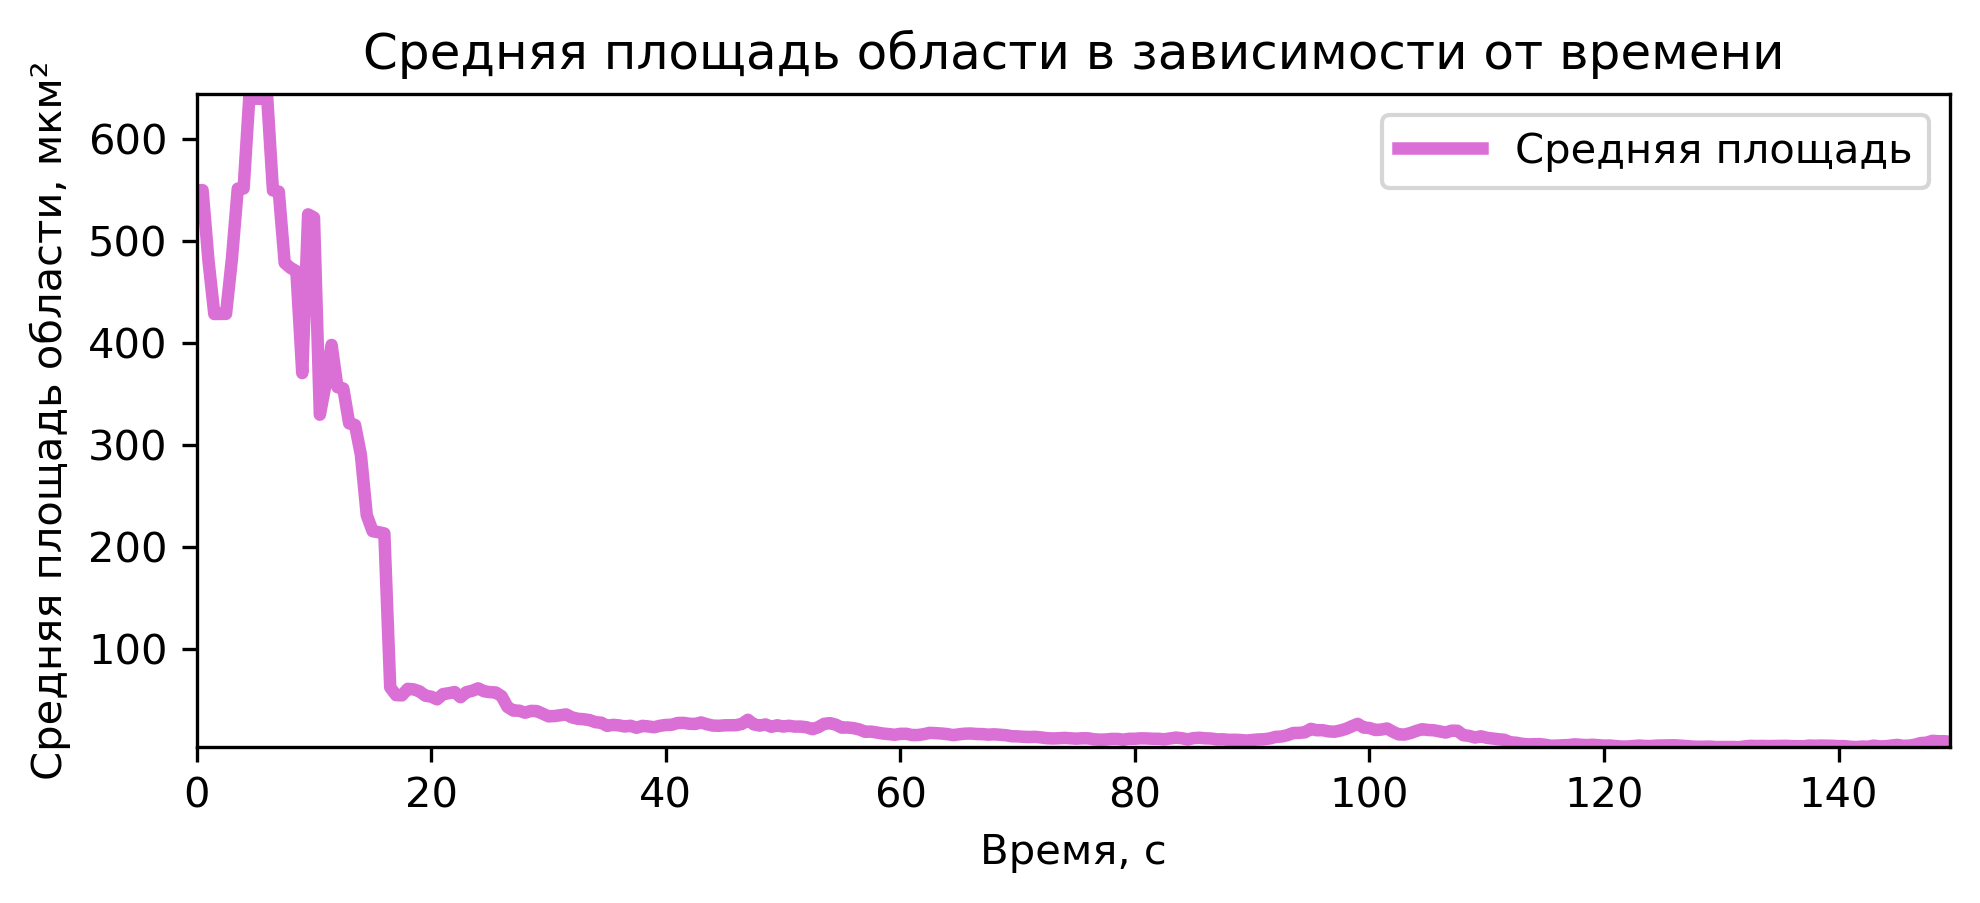

     time_seconds  average_area
0             0.0    549.961553
1             0.5    549.986269
2             1.0    481.271626
3             1.5    428.612927
4             2.0    428.736811
..            ...           ...
295         147.5      8.496732
296         148.0     10.330505
297         148.5      9.894073
298         149.0      9.949470
299         149.5      9.340572

[300 rows x 2 columns]


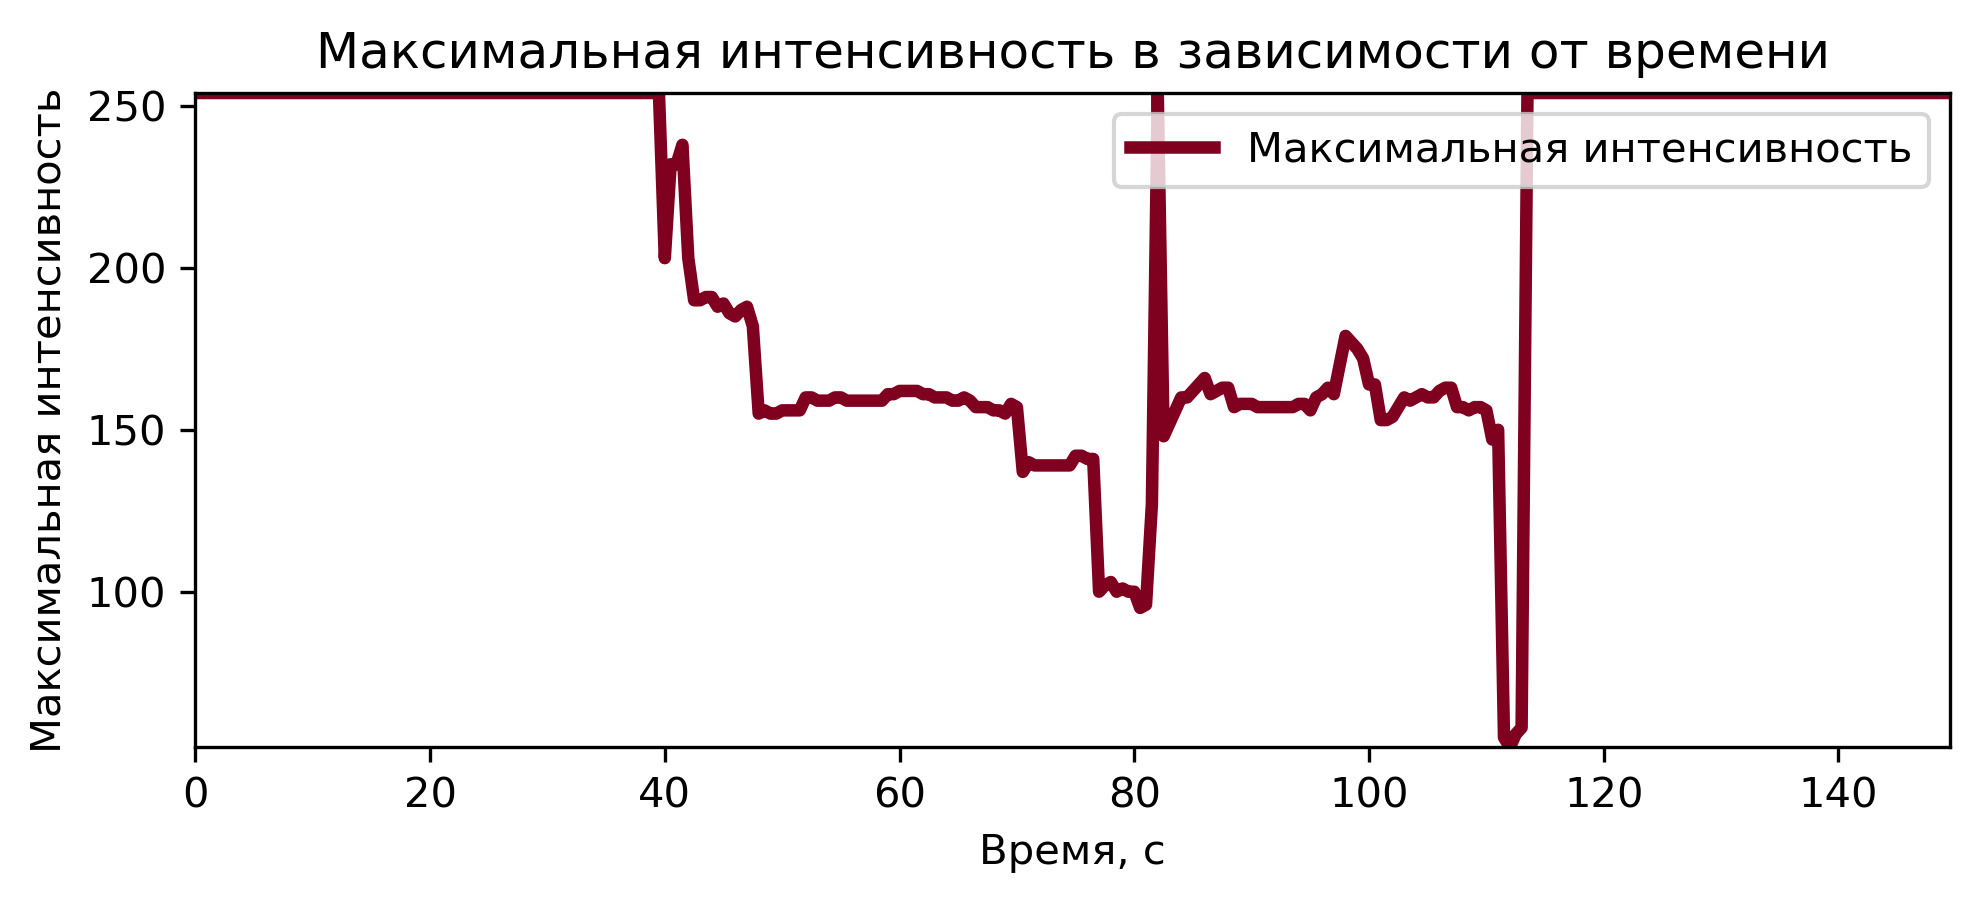

     time_seconds  max_intensity
0             0.0            254
1             0.5            254
2             1.0            254
3             1.5            254
4             2.0            254
..            ...            ...
295         147.5            254
296         148.0            254
297         148.5            254
298         149.0            254
299         149.5            254

[300 rows x 2 columns]


In [ ]:
import Astrocytes_Final_problem.src.functions.Common_function as Common_function

main_folder_path = r'C:\Users\Vector\Desktop\Final\General'
Common_function.function_runs_all_functions(main_folder_path)

### Ссылка на github репозиторий
https://github.com/bogushmaan/vector